In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

In [4]:
!python -m pip install git+https://github.com/nirum/jetplot


  Cloning https://github.com/nirum/jetplot to c:\users\marinag\appdata\local\temp\pip-req-build-oa_nkx9u
  Resolved https://github.com/nirum/jetplot to commit 7e2fc15049870523acb3318a38ffeec73c0dfb67
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --quiet https://github.com/nirum/jetplot 'C:\Users\marinag\AppData\Local\Temp\pip-req-build-oa_nkx9u'


In [5]:
import jetplot
import matplotlib.colors


### get original clustering outputs

In [6]:
glm_version = '24_events_all_L2_optimize_by_session'

In [7]:
# base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
# data_folder = '220622_across_session_norm_10_5_10'

# filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
# feature_matrix = pd.read_hdf(os.path.join(base_dir, data_folder, filename), key='df')

# filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
# df_meta = pd.read_hdf(os.path.join(base_dir, data_folder, filename))

# filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
# original_cluster_labels = pd.read_hdf(os.path.join(base_dir, data_folder, filename))

In [8]:
# # plot feature matrix sorted by cluster ID
# plotting.plot_feature_matrix_sorted(feature_matrix, df_meta, sort_col='cluster_id', save_dir=None,
#                                     folder=None)

### get GLM results (not across session normalized)

In [9]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat

#### for cells matched in 3 exp levels

In [10]:
version = '24_events_all_L2_optimize_by_session'

run_params, results, results_pivoted, weights_df = gfd.load_analysis_dfs(version)

loading run_params
loading results df
loading results_pivoted df
loading weights_df


In [11]:
results_pivoted = results_pivoted.set_index('identifier')

In [12]:
print(len(results_pivoted.ophys_experiment_id.unique()))
print(results_pivoted.experience_level.unique())

1248
['Familiar' 'Novel >1' 'Novel 1']


In [13]:
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))
print(results_pivoted.project_code.unique())
print(results_pivoted.session_type.unique())

1248
28806
['VisualBehaviorTask1B' 'VisualBehavior' 'VisualBehaviorMultiscope']
['OPHYS_1_images_B' 'OPHYS_2_images_B_passive' 'OPHYS_3_images_B'
 'OPHYS_4_images_A' 'OPHYS_5_images_A_passive' 'OPHYS_6_images_A'
 'OPHYS_1_images_A' 'OPHYS_3_images_A' 'OPHYS_2_images_A_passive'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B']


In [14]:
original_results_pivoted = results_pivoted.copy()

#### results for all experiments

In [15]:
# run_params, all_results, all_results_pivoted, all_weights_df = gfd.load_analysis_dfs(version)

In [16]:
# all_results_pkl = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\ophys_glm_results\24_events_all_L2_optimize_by_session_all_cells.pkl"

# all_results = pd.read_pickle(all_results_pkl)
# all_results = all_results.set_index('identifier')
# all_results.head()

In [17]:
# print(len(all_results.ophys_experiment_id.unique()))
# print(len(all_results.cell_specimen_id.unique()))
# print(all_results.project_code.unique())
# print(all_results.session_type.unique())

### get across session normalized dropout scores

In [18]:
# import visual_behavior_glm.GLM_across_session as gas

# # get across session normalized dropout scores
# df, failed_cells = gas.load_cells(glm_version, clean_df=True)
# df = df.set_index('identifier')

In [19]:
# # only use across session values
# across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
# results_pivoted = across.copy()
# # rename across session columns 
# results_pivoted = results_pivoted.rename(
#     columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
#              'behavioral_across': 'behavioral', 'task_across': 'task'})
# print(len(results_pivoted), 'len(results_pivoted)')

### get experiment and cell metadata for familiar active sessions

In [20]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [21]:
def get_cell_specimen_ids_matched_in_x_sessions(cells_table, x_sessions=3):
    """
    identifies cell_specimen_ids that are matched in at least x number of sessions in the input dataframe
    limit dataframe to a specific subset of session types to identify cells matched in that session type
    input dataframe must have column 'cell_specimen_id', such as in ophys_cells_table
    x_sessions: minimum number of sessions a cell has to be matched in
    """
    x_sessions = 3
    session_counts = cells_table.groupby(['cell_specimen_id']).count()[['ophys_session_id']]
    cells_in_x_sessions = session_counts[session_counts.ophys_session_id >= x_sessions]
    print('checking session counts:', cells_in_x_sessions.ophys_session_id.values[:20])
    cell_specimen_ids_in_x_sessions = cells_in_x_sessions.index.unique()
    print(len(cell_specimen_ids_in_x_sessions), 'cell_specimen_ids in at least', x_sessions, 'sessions')

    return cell_specimen_ids_in_x_sessions

In [22]:
def limit_to_familiar_active_sessions(df):
    """
    takes any input dataframe with 'experience_level' and 'passive' columns and removes everything that isnt 
    experience_level=Familiar with passive=False
    """
    # limit to active familiar session only
    df = df[(df.experience_level=='Familiar') & (df.passive==False)].copy()
    print(len(df.cell_specimen_id.unique()), 'familiar active cell_specimen_ids')
    return df

In [23]:
def add_familiar_active_session_number(cells_table):
    """
    limit to familiar active sessions, then add a column indicating the order of sessions relative to the first familiar active session
    input dataframe must have columns 'cell_specimen_id', 'date_of_acquisition', 'passive', and 'experience_level;
    and have only one row per cell_specimen_id - ophys_experiment_id combination
    """
    # limit to familiar active sessions only
    cells_table = limit_to_familiar_active_sessions(cells_table)
    # add a column indicating the session order 
    cells_table['familiar_active_session_number'] = np.nan
    cells_table = cells_table.sort_values(by=['cell_specimen_id', 'date_of_acquisition'])
    cells_table = cells_table.reset_index() # important to reset index so the following row assignment works properly
    for row in cells_table.index.values: 
        row_data = cells_table.loc[row]
        csid = row_data.cell_specimen_id
        this_session_id = row_data.ophys_session_id
        sorted_sessions = cells_table[cells_table.cell_specimen_id==csid].sort_values(by='date_of_acquisition')
        all_sessions = sorted_sessions.ophys_session_id.values
        session_number = np.where(all_sessions==this_session_id)[0][0]+1
        cells_table.at[row, 'familiar_active_session_number'] = int(session_number)
    print(len(cells_table.cell_specimen_id.unique()), 'familiar active cell_specimen_ids')
    print(len(cells_table.familiar_active_session_number.unique()), 'familiar active session numbers')
    return cells_table


In [24]:
def replace_experience_level_with_familiar_active_number(df):
    '''
    will go through every row in df and add the familiar active sesssion number to 'experience_level' column 
    limit to only familiar active session numbers first to prevent this from getting weird
    '''
     # add familiar active session number
    df = add_familiar_active_session_number(df)

    # add familiar active session number to experience level
    df['experience_level'] = [df.iloc[row].experience_level + ' ' + str(int(df.iloc[row].familiar_active_session_number)) for row in range(len(df))]
    print('experience_levels: ', df['experience_level'].unique())
    return df
    

In [25]:
def get_cells_matched_in_3_familiar_active_sessions():
    """
    returns a version of ophys_cells_table with 4x2 and Ai94 data removed,
    a new column called "familiar_active_session_number" that gives the order of familiar sessions after passive ones have been removed
    limits to cells matched in the first 3 familiar active sessions
    and modifies "experience_level" column to include the familiar active session number (ex: Familiar 1, Familiar 2, etc)
    """
    cache_dir = loading.get_platform_analysis_cache_dir()
    cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
    experiment_table = cache.get_ophys_experiment_table()
    # remove 4x2 and GC6s
    experiment_table = experiment_table[(experiment_table.project_code != 'VisualBehaviorMultiscope4areasx2d')]
    experiment_table = experiment_table[(experiment_table.reporter_line != 'Ai94(TITL-GCaMP6s)')]
    print(len(experiment_table), 'experiments')

    familiar_expts = experiment_table[(experiment_table.experience_level=='Familiar') & (experiment_table.passive==False)]
    print(len(familiar_expts), 'familiar active experiments')
    print(familiar_expts.experience_level.unique())
    print(familiar_expts.session_type.unique())

    cells_table = cache.get_ophys_cells_table()
    # merge in metadata, which also limits cells_table to the experiments in familiar_expts above (without 4x2 and Ai94)
    cells_table = cells_table.reset_index().merge(familiar_expts, on='ophys_experiment_id')
    # remove experiment that does not have GLM results
    cells_table = cells_table[cells_table.ophys_experiment_id!=856938751]
    print(len(cells_table.ophys_experiment_id.unique()), 'experiments in filtered cells table')

    # add familiar active session number
    familiar_cells = add_familiar_active_session_number(cells_table)

    # get cells that are in at least 3 sessions of this type
    matched_csids = get_cell_specimen_ids_matched_in_x_sessions(familiar_cells, x_sessions=3)
    matched_cells = familiar_cells[familiar_cells.cell_specimen_id.isin(matched_csids)]
    print(matched_cells.experience_level.unique())
    print(matched_cells.session_type.unique())

    # limit to the first 3 familiar active sessions
    matched_cells = matched_cells[matched_cells.familiar_active_session_number <= 3]
    print(len(matched_cells.cell_specimen_id.unique()), 'familiar active cell_specimen_ids in the first 3 sessions')
    print(len(matched_cells.familiar_active_session_number.unique()), 'familiar active session numbers')

    # add familiar active session number to experience level
    matched_cells = replace_experience_level_with_familiar_active_number(matched_cells)
    
    return matched_cells

In [26]:
cells_table = get_cells_matched_in_3_familiar_active_sessions()

1249 experiments
452 familiar active experiments
['Familiar']
['OPHYS_1_images_A' 'OPHYS_3_images_A' 'OPHYS_1_images_B'
 'OPHYS_3_images_B']
451 experiments in filtered cells table
17990 familiar active cell_specimen_ids
17990 familiar active cell_specimen_ids
5 familiar active session numbers
checking session counts: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
1450 cell_specimen_ids in at least 3 sessions
['Familiar']
['OPHYS_3_images_A' 'OPHYS_1_images_A' 'OPHYS_1_images_B'
 'OPHYS_3_images_B']
1450 familiar active cell_specimen_ids in the first 3 sessions
3 familiar active session numbers
1450 familiar active cell_specimen_ids
1450 familiar active cell_specimen_ids
3 familiar active session numbers
experience_levels:  ['Familiar 1' 'Familiar 2' 'Familiar 3']


#### limit GLM results to matched cells and reformat

In [27]:
results_pivoted.experience_level.unique()

array(['Familiar', 'Novel >1', 'Novel 1'], dtype=object)

In [28]:
# add unique identifier for ophys_expt_id + csid pairs so it can be merged with results_pivoted
cells_table['identifier'] = [str(cells_table.iloc[row].ophys_experiment_id)+'_'+str(cells_table.iloc[row].cell_specimen_id) for row in range(len(cells_table))]
cells_table = cells_table.set_index('identifier')

In [29]:
# add new experience levels for familiar active sessions to results pivoted
# and limit results pivoted to cells matched in 3 familiar sessions
results_pivoted = results_pivoted.drop(columns='experience_level')
results_pivoted = results_pivoted.merge(cells_table[[ 'experience_level']], on='identifier')
results_pivoted.experience_level.unique()

array(['Familiar 1', 'Familiar 2', 'Familiar 3'], dtype=object)

In [30]:
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))
print(results_pivoted.project_code.unique())
print(results_pivoted.session_type.unique())

171
1450
['VisualBehaviorTask1B' 'VisualBehavior' 'VisualBehaviorMultiscope']
['OPHYS_1_images_B' 'OPHYS_3_images_B' 'OPHYS_1_images_A'
 'OPHYS_3_images_A']


In [31]:
# limit to features used for clustering
features = processing.get_features_for_clustering()
features = ['all-images', 'omissions', 'task', 'behavioral']
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [32]:
len(results_pivoted)

4350

In [33]:
len(cells_table)

4350

In [34]:
print(len(cells_table.ophys_experiment_id.unique()))
print(len(cells_table.cell_specimen_id.unique()))
print(cells_table.project_code.unique())
print(cells_table.session_type.unique())

171
1450
['VisualBehavior' 'VisualBehaviorTask1B' 'VisualBehaviorMultiscope']
['OPHYS_3_images_A' 'OPHYS_1_images_A' 'OPHYS_1_images_B'
 'OPHYS_3_images_B']


# cluster on all cells 

I had to pull out and adapt bits of code from VBA to run on all cre lines because most VBA code loops through cre lines within the main functions - needs to be modularized

In [35]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_familiar_090623')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
folder = 'figs'

In [36]:
feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

No duplicated cells found
1450


In [37]:
# there were 1163 excitatory cells in iryna's 3 familiar session analysis

In [38]:
cells_table.groupby(['cre_line', 'experience_level']).count()

level_0  index  cell_roi_id  \
cre_line          experience_level                                
Slc17a7-IRES2-Cre Familiar 1           1163   1163         1163   
                  Familiar 2           1163   1163         1163   
                  Familiar 3           1163   1163         1163   
Sst-IRES-Cre      Familiar 1            149    149          149   
                  Familiar 2            149    149          149   
                  Familiar 3            149    149          149   
Vip-IRES-Cre      Familiar 1            138    138          138   
                  Familiar 2            138    138          138   
                  Familiar 3            138    138          138   

                                    cell_specimen_id  ophys_experiment_id  \
cre_line          experience_level                                          
Slc17a7-IRES2-Cre Familiar 1                    1163                 1163   
                  Familiar 2                    1163                 1163   
                  Familiar 3                    1163                 1163   
Sst-IRES-Cre      Familiar 1                     149                  149   
                  Familiar 2                     149                  149   
                  Familiar 3                     149                  149   
Vip-IRES-Cre      Familiar 1                     138                  138   
                  Familiar 2                     138                  138   
                  Familiar 3                     138                  138   

                                    equipment_name  full_genotype  mouse_id  \
cre_line          experience_level                                            
Slc17a7-IRES2-Cre Familiar 1                  1163           1163      1163   
                  Familiar 2                  1163           1163      1163   
                  Familiar 3                  1163           1163      1163   
Sst-IRES-Cre      Familiar 1                   149            149       149   
                  Familiar 2                   149            149       149   
                  Familiar 3                   149            149       149   
Vip-IRES-Cre      Familiar 1                   138            138       138   
                  Familiar 2                   138            138       138   
                  Familiar 3                   138            138       138   

                                    reporter_line  driver_line  ...  \
cre_line          experience_level                              ...   
Slc17a7-IRES2-Cre Familiar 1                 1163         1163  ...   
                  Familiar 2                 1163         1163  ...   
                  Familiar 3                 1163         1163  ...   
Sst-IRES-Cre      Familiar 1                  149          149  ...   
                  Familiar 2                  149          149  ...   
                  Familiar 3                  149          149  ...   
Vip-IRES-Cre      Familiar 1                  138          138  ...   
                  Familiar 2                  138          138  ...   
                  Familiar 3                  138          138  ...   

                                    ophys_container_id  project_code  \
cre_line          experience_level                                     
Slc17a7-IRES2-Cre Familiar 1                      1163          1163   
                  Familiar 2                      1163          1163   
                  Familiar 3                      1163          1163   
Sst-IRES-Cre      Familiar 1                       149           149   
                  Familiar 2                       149           149   
                  Familiar 3                       149           149   
Vip-IRES-Cre      Familiar 1                       138           138   
                  Familiar 2                       138           138   
                  Familiar 3                       138           138   

     


## load or generate clustering results


In [39]:
n_clusters = 7 # arbitrary choice that happens to pull out similar clusters to within cre clustering

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    print('loading results')
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
# otherwise run it and save it
else: 
    # run spectral clustering and get co-clustering matrix
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(100))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_path = os.path.join(save_dir, 'coclustering_matrix_n_'+str(n_clusters)+'_clusters.h5')
    coclustering_df.to_hdf(coclust_save_path, key='df', format='table')


    # run agglomerative clustering on co-clustering matrix to identify cluster labels
    from sklearn.cluster import AgglomerativeClustering
    X = coclustering_df.values
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                                    linkage='average')
    labels = cluster.fit_predict(X)
    cell_specimen_ids = coclustering_df.index.values
    # make dictionary with labels for each cell specimen ID in this cre line
    labels_dict = {'labels': labels, 'cell_specimen_id': cell_specimen_ids}
    # turn it into a dataframe
    labels_df = pd.DataFrame(data=labels_dict, columns=['labels', 'cell_specimen_id'])
    # get new cluster_ids based on size of clusters and add to labels_df
    cluster_size_order = labels_df['labels'].value_counts().index.values
    # translate between original labels and new IDS based on cluster size
    labels_df['cluster_id'] = [np.where(cluster_size_order == label)[0][0] for label in labels_df.labels.values]
    # concatenate with df for all cre lines
    cluster_labels = labels_df

    # limit cells_table to cells in feature_matrix and drop duplicates 
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    # cluster_meta will only have one row per cell_specimen_id 

    cluster_meta = cluster_labels[['cell_specimen_id', 'cluster_id', 'labels']].merge(cell_metadata, on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
    # annotate & clean cluster metadata
    cluster_meta = processing.clean_cluster_meta(cluster_meta)  # drop cluster IDs with fewer than 5 cells in them
    cluster_meta['original_cluster_id'] = cluster_meta.cluster_id

    # plot coclustering matrix - need to hack it since it assumes cre lines
    coclustering_dict = {}
    coclustering_dict['all'] = coclustering_df
    cluster_meta_tmp = cluster_meta.copy()
    cluster_meta_tmp['cre_line'] = 'all'
    plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
                                                    save_dir=save_dir, folder=folder, suffix='_'+str(n_clusters)+'_clusters', ax=None)

    # add within cluster correlation
    cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=True)

    # save clustering results
    print('saving results')
    cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')
    cluster_data = cluster_meta.reset_index()[['cell_specimen_id', 'ophys_experiment_id', 'cre_line', 'cluster_id', 'labels', 'within_cluster_correlation_p']]
    cluster_data.to_hdf(cluster_meta_save_path, key='df', format='table')



loading results
1450 cells in cell_metadata for feature_matrix


In [40]:
feature_matrix.head()

all-images                        omissions             \
experience_level Familiar 1 Familiar 2 Familiar 3 Familiar 1 Familiar 2   
cell_specimen_id                                                          
1086491395         0.744411   0.372261   0.980643        0.0        0.0   
1086491508         0.000000   0.000000   0.000000        0.0        0.0   
1086491716         0.000000   0.000000   0.000000        0.0        0.0   
1086491863         0.000000   0.000000   0.000000        0.0        0.0   
1086492072         0.000000   0.000000   0.000000        0.0        0.0   

                                  task                       behavioral  \
experience_level Familiar 3 Familiar 1 Familiar 2 Familiar 3 Familiar 1   
cell_specimen_id                                                          
1086491395              0.0        0.0        0.0        0.0   0.213908   
1086491508              0.0        0.0        0.0        0.0   0.000000   
1086491716              0.0        0.0        0.0        0.0   0.000000   
1086491863              0.0        0.0        0.0        0.0   0.000000   
1086492072              0.0        0.0        0.0        0.0   0.000000   

                                        
experience_level Familiar 2 Familiar 3  
cell_specimen_id                        
1086491395         0.614764   0.092488  
1086491508         0.000000   0.000000  
1086491716         0.000000   0.000000  
1086491863         0.000000   0.000000  
1086492072         0.000000   0.000000

### plot coding scores for clusters

In [41]:
cells_table.experience_level.unique()

array(['Familiar 1', 'Familiar 2', 'Familiar 3'], dtype=object)

In [42]:
def plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', orient='horiz', session_colors=True,
                                    save_dir=None, folder=None, ax=None):
    """
    Plot heatmap of all cells coding scores, sorted by cluster_id (or some other column of cluster_meta)
    with lines between clusters. 
    cluster_meta: dataframe of cell metadata, indexed by cell_specimen_id, with the cluster_id for each cell_specimen_id
    feature_matrix: dataframe of coding score values, indexed by cell_specimen_id
    sort_by: column in cluster_meta to sort the cells by, should be 'cluster_id' or similar identifier for what cluster / group a cell belongs to
    orient: 'horiz' or 'vert'; whether to orient the plot vertically (cells on y axis, coding socres on x) or horizontally (cells on x axis, coding scores on y)
    session_colors: if True, will plot the coding score values using the color of the experience level for that coding score
                    if False, default colormap will be used ("Blues_r")
    """

    sorted_cluster_meta = cluster_meta.sort_values(by=sort_by)
    cell_order = sorted_cluster_meta.index.values
    label_values = sorted_cluster_meta[sort_by].values
    n_clusters = len(sorted_cluster_meta[sort_by].unique())

    # get data from feature matrix for this set of cells
    data = feature_matrix.loc[cell_order].copy()

    # Kyle's colors
    c_vals = ['#e53e3e', '#3182ce', '#805ad5',] #v6

    # orient = 'horiz'
    # session_colors = False

    if orient == 'vert':
        figsize = (5,10)
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(data.values, cmap='Blues', ax=ax, vmin=0, vmax=1, 
                            robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

        for x in [3, 6, 9]:
            ax.axvline(x=x, ymin=0, ymax=data.shape[0], color='gray', linestyle='--', linewidth=1)
        # ax.set_title('n = '+str(n_clusters)+' clusters')
        ax.set_ylabel('cells')
        ax.set_ylim(0, data.shape[0])
        ax.set_yticks([0, data.shape[0]])
        ax.set_yticklabels((0, data.shape[0]), fontsize=14)
        ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
        ax.set_xlabel('')
        ax.set_xlim(0, data.shape[1])
        ax.set_xticks(np.arange(0, data.shape[1]) + 0.5)
        # if use_abbreviated_labels:
        #     xticklabels = [get_abbreviated_experience_levels([key[1]])[0] + ' -  ' + get_abbreviated_features([key[0]])[0].upper() for key in list(data.keys())]
        #     ax.set_xticklabels(xticklabels, rotation=90, fontsize=14)
        # else:
        ax.set_xticklabels([key[1] + ' -  ' + key[0] for key in list(data.keys())], rotation=90, fontsize=14)

        # plot a line at the division point between clusters
        cluster_divisions = np.where(np.diff(label_values) == 1)[0]
        for y in cluster_divisions:
            ax.hlines(y, xmin=0, xmax=data.shape[1], color='k')

    elif orient == 'horiz':
        figsize = (8,3.5)
        fig, ax = plt.subplots(figsize=figsize)

        # remap coding scores to experience level colors
        # coding_scores_unmod = data.values.copy()
        coding_scores_remapped = data.values.copy()

        if session_colors:
            vmax = 5
            colors = experience_level_colors
            # colors = c_vals # Kyle's colors
            coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0], "white", colors[1], "white", colors[2]])

            # familiar sessions are in scale of 0-1 already
            # add 2 to novel sessions to make them in the scale of colors[1]
            for idx in (1, 4, 7, 10): # Remap certain sessions to new values
                coding_scores_remapped[:, idx] = coding_scores_remapped[:, idx] + 2
            # add 4 to novel + sessions to make them in the scale of colors[2]
            for idx in (2, 5, 8, 11):
                coding_scores_remapped[:, idx] = coding_scores_remapped[:, idx] + 4
        else:
            vmax = 1
            colors = experience_level_colors.copy()
            coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0]])
            vmax = 1

        # data = data.T.copy()
        coding_scores_remapped = coding_scores_remapped.T.copy()


        ax = sns.heatmap(coding_scores_remapped, cmap=coding_score_cmap, ax=ax, vmin=0, vmax=vmax, 
                            robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

        for y in [3, 6, 9]:
            ax.axhline(y=y, xmin=0, xmax=coding_scores_remapped.shape[0], color='gray', linestyle='--', linewidth=1)
        # ax.set_title('n = '+str(n_clusters)+' clusters')
        ax.set_xlabel('cells')
        ax.set_xlim(0, coding_scores_remapped.shape[1])
        ax.set_xticks([0, coding_scores_remapped.shape[1]])
        ax.set_xticklabels((0, coding_scores_remapped.shape[1]))
        # ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
        ax.set_ylabel('')
        ax.set_ylim(0, coding_scores_remapped.shape[0])

        # set y ticks to F, N, N+ with correct colors
        ax.set_yticks(np.arange(12)+0.5)
        
        if session_colors:
            ax.set_yticklabels(['F', 'N', 'N+', 'F', 'N', 'N+', 'F', 'N', 'N+', 'F', 'N', 'N+'], va='center', rotation=0)
            c_vals = experience_level_colors.copy()
            [
                t.set_color(i) for (i,t) in zip([
                    c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2],
                    c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2]
                ], ax.yaxis.get_ticklabels())
            ]
        else: 
            ax.set_yticklabels(['F1', 'F2', 'F3', 'F1', 'F2', 'F1', 'F1', 'F2', 'F3', 'F1', 'F2', 'F3'], va='center', rotation=0)
            # pass

        ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so image clusters are on top

        # iterate through clusters, get size of cluster, set tick location for middle of cluster
        cell_count = 0
        cluster_ticks = []
        for cluster_id in range(n_clusters):
            n_cells_in_cluster = len(cluster_meta[cluster_meta[sort_by]==cluster_id])
            cluster_ticks.append(cell_count + n_cells_in_cluster/2)
            cell_count += n_cells_in_cluster
        # plot labels for cluster IDS
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel('Cluster ID')
        ax2.set_xticks(cluster_ticks)
        ax2.set_xticklabels(np.arange(1, n_clusters+1))

        # plot a line at the division point between clusters
        cluster_divisions = np.where(np.diff(label_values) == 1)[0]
        for x in cluster_divisions:
            ax.vlines(x, ymin=0, ymax=coding_scores_remapped.shape[1], color='k')

    if save_dir:
        fig.subplots_adjust(wspace=0.7)
        utils.save_figure(fig, figsize, save_dir, folder, 'feature_matrix_n_clusters_'+str(n_clusters)+'_'+orient+'_'+sort_by+'_sort')

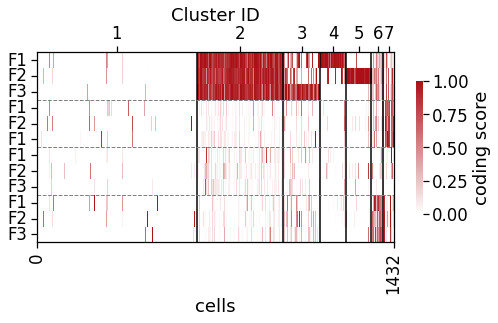

In [43]:
plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', orient='horiz', session_colors=False,
                                    save_dir=save_dir, folder=folder, ax=None)

### cluster averages

In [44]:
def remap_coding_scores_to_experience_level_colors(coding_scores):
    """
    coding_scores is an array where rows are cells (or cluster ids) and columns are experience level / coding feature combinations
    """
    coding_scores_remapped = coding_scores.copy()
    
    colors = experience_level_colors.copy()
    # colors = c_vals # Kyle's colors
    coding_score_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0], "white", colors[1], "white", colors[2]])

    # familiar sessions are in scale of 0-1 already
    # add 2 to novel sessions to make them in the scale of colors[1]
    coding_scores_remapped.loc[:, (slice(None), "Novel 1")] += 2
    coding_scores_remapped.loc[:, (slice(None), "Novel >1")] += 4

    # return max value for plotting
    vmax = 5

    return coding_scores_remapped, coding_score_cmap, vmax

In [45]:
def get_cluster_means(feature_matrix, cluster_meta):
    """
    adds cluster_id column to feature_matrix then groups by the cluster ID to compute the mean of each cluster
    """
    cluster_means = feature_matrix.merge(cluster_meta[['cluster_id']], on='cell_specimen_id').groupby('cluster_id').mean()
    # reset column values so they arent tuples
    columns = pd.MultiIndex.from_tuples(cluster_means.columns)
    cluster_means.columns = columns
    return cluster_means

In [46]:
def get_cre_line_means(feature_matrix, cluster_meta):
    """
    adds cluster_id column to feature_matrix then groups by the cre line to compute the mean of each cre line
    """
    cre_line_means = feature_matrix.merge(cluster_meta[['cre_line']], on='cell_specimen_id').groupby('cre_line').mean()
    # reset column values so they arent tuples
    columns = pd.MultiIndex.from_tuples(cre_line_means.columns)
    cre_line_means.columns = columns
    return cre_line_means

In [47]:
def get_clean_labels_for_coding_scores_df(coding_scores, columns=False): 
    """
    coding_scores should be a data frame with cells or clusters as colums (or indices) and 
    (coding score category - experience level) as multi-index columms (or indices)
    specify axis to transform by setting columns to True or False
    """
    if columns:
        experience_level_labels = coding_scores.columns.get_level_values(1)
    else:
        experience_level_labels = coding_scores.index.get_level_values(1)
    exp_level_abbreviations = [exp_level.split(' ')[0][0] if len(exp_level.split(' ')) == 1 else exp_level.split(' ')[0][0] + exp_level.split(' ')[1][:2] for exp_level in experience_level_labels]
    # manually label feature categories
    # feature_labels = ['', 'images', '', '', 'omissions', '', '', 'behavioral', '', '', 'task', '']
    # new_labels = pd.MultiIndex.from_arrays((feature_labels, exp_level_abbreviations))
    new_labels = exp_level_abbreviations
    return new_labels

In [48]:
def get_abbreviated_exp_levels(experience_levels): 
    """
    """
    exp_level_abbreviations = [exp_level.split(' ')[0][0] if len(exp_level.split(' ')) == 1 else exp_level.split(' ')[0][0] + exp_level.split(' ')[1][:2] for exp_level in experience_levels]
    return exp_level_abbreviations

In [49]:
def color_yaxis_labels_by_experience(ax):
    """
    iterates through y-axis tick labels and sets them to experience level colors in an alternating way,
    assuming that the labels are in [F, N, N+] order for the 4 feature categories (images, omission, behvaioral, task)
    """
    c_vals = utils.get_experience_level_colors()
    [t.set_color(i) for (i,t) in zip([
            c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2],
            c_vals[0], c_vals[1], c_vals[2], c_vals[0], c_vals[1], c_vals[2]
        ], ax.yaxis.get_ticklabels())]


In [50]:
def plot_cre_line_means_heatmap(cre_line_means, experience_colors=True, colorbar=False, ax=None):
    """
    plots a heatmap of mean coding score values for each cre line, 
    remap the colormap to use experience level colors if experience_colors = True, else use familiar colors

    cre_line_means: dataframe with cre lines as columns and feature-experience combinations as rows, values are mean coding scores per cre line
    """
    if experience_colors:
        # remap to session colors
        cre_line_means, cmap, vmax = remap_coding_scores_to_experience_level_colors(cre_line_means)
    else: 
        colors = experience_level_colors.copy()
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0]])
        vmax = 1
        
    ax = sns.heatmap(cre_line_means, cmap=cmap, vmin=0, vmax=vmax, square=False, cbar=colorbar, ax=ax, annot=True, fmt=".2f")
    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    # abbreviate exp level labels
    ax.set_yticklabels(get_clean_labels_for_coding_scores_df(cre_line_means, columns=False))
    ax.set_ylabel('')
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_line_means.columns.values])
    ax.set_xlabel('')
    ax.set_title('avg.\ncoding')
    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax.axhline(y=y, xmin=0, xmax=cre_line_means.shape[0], color='gray', linestyle='--', linewidth=1)

    # colorize y axis labels
    if experience_colors: 
        color_yaxis_labels_by_experience(ax)

    return ax


In [51]:
def plot_cre_line_means(feature_matrix, cluster_meta, experience_colors=True):
    """
    Get the average coding score values for each cre line and plot as a heatmap, 
    remap the colormap to use experience level colors if experience_colors = True, else use familiar colors,
    translate the dataframe so that cre lines are columns and rows are feature-experience combos, 
    abbreviate the labels for aesthetics, then plot
    """
    cre_line_means = get_cre_line_means(feature_matrix, cluster_meta)

    # translate so rows are clusters and columns are cre lines
    cre_line_means = cre_line_means.T.copy()

    figsize = (3, 5)
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_cre_line_means_heatmap(cre_line_means, experience_colors=experience_colors, colorbar=False, ax=None)

    if experience_colors:
        suffix = '_exp_level_colors'
    else: 
        suffix = '_familiar_colors'
    # save
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder, 'cre_line_means'+suffix)
    return ax

c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


<AxesSubplot:title={'center':'avg.\ncoding'}>

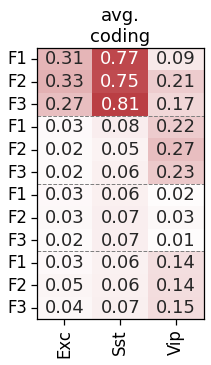

In [52]:
plot_cre_line_means(feature_matrix, cluster_meta, experience_colors=False)

In [53]:
def plot_cluster_means_heatmap(cluster_means, experience_colors=False, colorbar=False, ax=None):
    """
    plots a heatmap of cluster mean values
    remap the colormap to use experience level colors if experience_colors = True, else use familiar colors

    cluster_means: dataframe with clusters as columns and feature-experience combinations as rows, values are mean coding scores per cluster
    """
    if experience_colors:
        # remap to session colors
        cluster_means, cmap, vmax = remap_coding_scores_to_experience_level_colors(cluster_means)
    else: 
        colors = experience_level_colors.copy()
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0]])
        vmax = 1
        
    if ax is None: 
        figsize = (8,5)
        fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(cluster_means, cmap=cmap, vmin=0, vmax=vmax, square=True, cbar=colorbar, ax=ax)
    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    ax.set_yticklabels(get_clean_labels_for_coding_scores_df(cluster_means, columns=False))
    ax.set_title('cluster averages')
    ax.set_xlabel('cluster ID')
    ax.set_ylabel('')
    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax.axhline(y=y, xmin=0, xmax=cluster_means.shape[0], color='gray', linestyle='--', linewidth=1)
    # dotted gray lines every 3rd cluster
    for x in [3, 6, 9]:
        ax.axvline(x=x, ymin=0, ymax=cluster_means.shape[0], color='gray', linestyle='--', linewidth=1)

    # label feature categories on right
    fontsize = 14
    rotation = -90
    n_clusters = len(cluster_means.columns)
    ax.text(s='images', x=n_clusters+0.25, y=1.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    ax.text(s='omissions', x=n_clusters+0.28, y=4.4, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    ax.text(s='behavioral', x=n_clusters+0.25, y=7.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')
    ax.text(s='task', x=n_clusters+0.28, y=10.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='left')

    # colorize y axis labels if using session colors
    if experience_colors:
        color_yaxis_labels_by_experience(ax)

    return ax


In [54]:
def plot_cluster_means(feature_matrix, cluster_meta, experience_colors=False, save_dir=None, folder=None, ax=None): 
    """
    Get the average coding score values for each cluster and plot as a heatmap
    optionally remap the colormap to use experience level colors if experience_colors=True, else use familiar color
    Translate the dataframe so that clusters are columns and rows are feature-experience combos, 
    abbreviate the labels for aesthetics, then plot
    """
    # compute cluster means
    cluster_means = get_cluster_means(feature_matrix, cluster_meta)
    # translate the df so clusters are cols and feature-exp are rows
    cluster_means = cluster_means.T.copy()

    # make the plot
    figsize = (8,5)
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_cluster_means_heatmap(cluster_means, experience_colors=experience_colors, colorbar=False, ax=ax)    
    if experience_colors:
        suffix = '_experience_colors'
    else: 
        suffix = '_familiar_colors'
    suffix = suffix + '_n_'+str(len(cluster_means.columns))
    # save
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder, 'cluster_means'+suffix)
    return ax




<AxesSubplot:title={'center':'cluster averages'}, xlabel='cluster ID'>

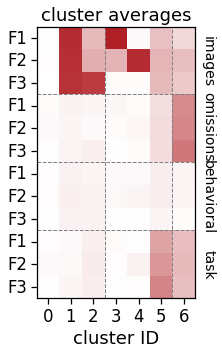

In [55]:
plot_cluster_means(feature_matrix, cluster_meta, experience_colors=False, save_dir=save_dir, folder=folder, ax=None)

In [56]:
def plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', experience_colors=False, cbar=False,
                                    save_dir=None, folder=None, ax=None):
    """
    Plot heatmap of all cells coding scores, sorted by cluster_id (or some other column of cluster_meta)
    with lines between clusters. 
    cluster_meta: dataframe of cell metadata, indexed by cell_specimen_id, with the cluster_id for each cell_specimen_id
    feature_matrix: dataframe of coding score values, indexed by cell_specimen_id
    sort_by: column in cluster_meta to sort the cells by, should be 'cluster_id' or similar identifier for what cluster / group a cell belongs to
    orient: 'horiz' or 'vert'; whether to orient the plot vertically (cells on y axis, coding socres on x) or horizontally (cells on x axis, coding scores on y)
    session_colors: if True, will plot the coding score values using the color of the experience level for that coding score
                    if False, default colormap will be used ("Blues_r")
    """

    if sort_by is not None: 
        sorted_cluster_meta = cluster_meta.sort_values(by=sort_by)
        label_values = sorted_cluster_meta[sort_by].values
        n_clusters = len(sorted_cluster_meta[sort_by].unique())
    else: 
        sorted_cluster_meta = cluster_meta.copy()
    cell_order = sorted_cluster_meta.index.values

    # get data from feature matrix for this set of cells
    coding_scores = feature_matrix.loc[cell_order].copy()

    # Kyle's colors
    # c_vals = ['#e53e3e', '#3182ce', '#805ad5',] #v6

    if experience_colors:
        # remap to session colors
        coding_scores, cmap, vmax = remap_coding_scores_to_experience_level_colors(coding_scores)
    else: 
        colors = experience_level_colors.copy()
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[0]])
        vmax = 1

    # translate so rows are feature-exp combos and columns are cells
    coding_scores = coding_scores.T.copy()

    # relabel dataframe indices to be abbreviated experience labels (without feature categories)
    new_labels = get_clean_labels_for_coding_scores_df(coding_scores, columns=False)
    coding_scores.index = new_labels

    figsize = (12,5)
    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.heatmap(coding_scores, cmap=cmap, ax=ax, vmin=0, vmax=vmax, 
                        robust=True, cbar=cbar, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax.axhline(y=y, xmin=0, xmax=coding_scores.shape[0], color='gray', linestyle='--', linewidth=1)

    # y-axis formtting
    # ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
    ax.set_ylabel('')
    ax.set_ylim(0, coding_scores.shape[0])
    # set y ticks to F, N, N+ with correct colors
    # ax.set_yticks(np.arange(n_clusters)+0.5)
    # ax.set_yticklabels(rotation=90)
    ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so image clusters are on top

    if experience_colors: # colorize y axis labels
        color_yaxis_labels_by_experience(ax)

    # x-axis formatting
    # iterate through clusters, get size of cluster, set tick location for middle of cluster
    if sort_by is not None:
        cell_count = 0
        cluster_ticks = []
        for cluster_id in range(n_clusters):
            n_cells_in_cluster = len(cluster_meta[cluster_meta[sort_by]==cluster_id])
            cluster_ticks.append(cell_count + n_cells_in_cluster/2)
            cell_count += n_cells_in_cluster
        # plot bottom x labels for cluster IDS
        ax.set_xlabel('cluster ID')
        ax.set_xticks(cluster_ticks)
        ax.set_xticklabels(np.sort(cluster_meta.cluster_id.unique()), rotation=0)
        ax.set_xlim(0, coding_scores.shape[1])

        # top x labels for cells
        ax2 = ax.twiny()
        # ax2.set_xlabel('cells')
        ax2.text(s='cells', x=coding_scores.shape[1]/2, y=-0.5, ha='center')
        # ax.set_xlim(ax.get_xlim())
        ax2.set_xlim(0, coding_scores.shape[1])
        ax2.set_xticks([0, coding_scores.shape[1]])
        ax2.set_xticklabels((0, coding_scores.shape[1]), rotation=0)
    else: 
        ax.set_xlim(0, coding_scores.shape[1])
        ax.set_xticks([0, coding_scores.shape[1]])
        ax.set_xticklabels((0, coding_scores.shape[1]), rotation=0)
        ax.set_xlabel('cells')

    # plot a line at the division point between clusters
    if sort_by is not None:
        cluster_divisions = np.where(np.diff(label_values) == 1)[0]
        for x in cluster_divisions:
            ax.vlines(x, ymin=0, ymax=coding_scores.shape[1], color='k')

    # label feature categories on left
    rotation = 0
    fontsize = 16
    ax.text(s='images', x=-300.25, y=1.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
    ax.text(s='omissions', x=-300.28, y=4.4, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
    ax.text(s='behavioral', x=-300.25, y=7.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
    ax.text(s='task', x=-300.28, y=10.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')

    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

    if save_dir:
        fig.subplots_adjust(wspace=0.7)
        utils.save_figure(fig, figsize, save_dir, folder, 'feature_matrix_n_clusters_'+str(n_clusters)+'_remapped_'+sort_by+'_sort')

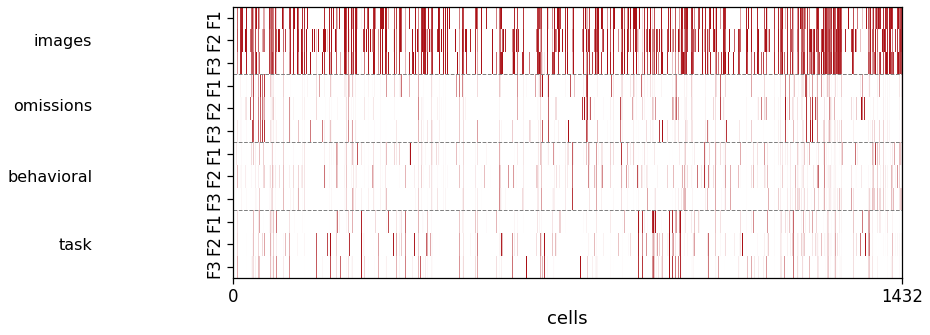

In [57]:
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, experience_colors=False,
                                    save_dir=None, folder=None, ax=None)

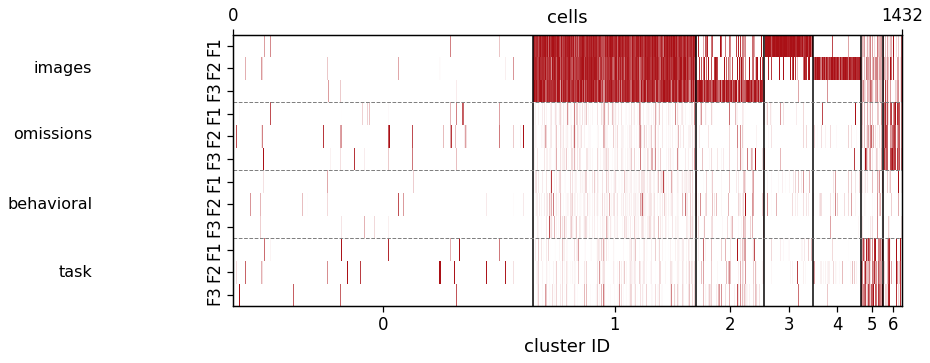

In [58]:
plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', experience_colors=False,
                                    save_dir=None, folder=None, ax=None)

<AxesSubplot:title={'center':'cluster averages'}, xlabel='cluster ID'>

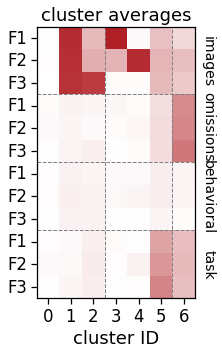

In [59]:
plot_cluster_means(feature_matrix, cluster_meta, save_dir=None, folder=None, ax=None)

### fraction cells per cluster per cre

In [60]:
def get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group='mouse_id'):
    """
    counts the number of cells a given condition, and the number of cells in each cluster for that given ocndition,
    then computes the proportion of cells in each cluster for the given condition
    col_to_group: can be 'cre_line', 'mouse_id', etc
    """
    # get number of cells in each group defined by col_to_group
    n_cells_group = cluster_meta.groupby([col_to_group]).count()[['cluster_id']].reset_index().rename(columns={'cluster_id':'n_cells_group'})
    # get number of cells in each cluster for each group
    n_cells_per_cluster = cluster_meta.groupby([col_to_group, 'cluster_id']).count()[['ophys_experiment_id']].reset_index().rename(columns={'ophys_experiment_id':'n_cells_cluster'})
    # add n cells per cluster per group to total number of cells per group and compute the fraction per cluster in each group
    n_cells_per_cluster = n_cells_per_cluster.merge(n_cells_group, on=col_to_group)
    n_cells_per_cluster['fraction_per_cluster'] = n_cells_per_cluster.n_cells_cluster/n_cells_per_cluster.n_cells_group
    
    return n_cells_per_cluster

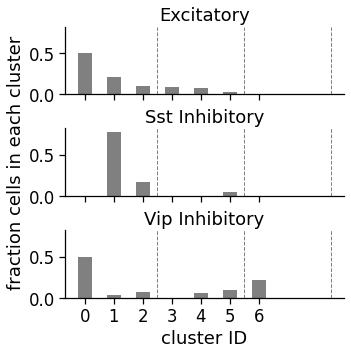

In [61]:
# sorted within cre
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

cre_lines = np.sort(cluster_meta.cre_line.unique() )

figsize = (5,5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre_line]
    order = np.sort(cluster_meta.cluster_id.unique())
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x='cluster_id', order=order, y='fraction_per_cluster', 
                color='gray', width=0.5, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    # ax[i].set_ylim(0, 0.3)
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    # dotted gray lines every 3rd cluster
    for x in [2.5, 5.5, 8.5]:
        ax[i].axvline(x=x, ymin=0, color='gray', linestyle='--', linewidth=1)

ax[1].set_ylabel('fraction cells in each cluster')
ax[i].set_xlabel('cluster ID')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)

### average dropouts per cluster

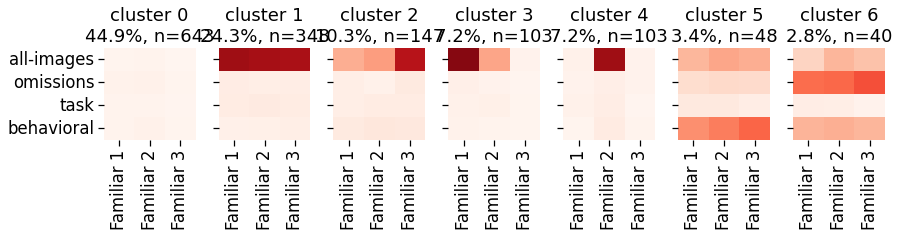

In [62]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)

figsize = (n_clusters_to_plot*2, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap='Reds', vmin=0, vmax=1, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_'+str(n_clusters))

### how many cells per cluster per mouse

In [63]:
# cre_line = 'Vip-IRES-Cre'
# cluster_meta[cluster_meta.cre_line==cre_line].groupby(['cre_line', 'mouse_id', 'cluster_id']).count().rename(columns={'labels':'n_cells'})[['n_cells']][:50]

### heatmaps of image response per cluster

In [64]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = ''

In [65]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

change_mdf = multi_session_df[multi_session_df.is_change==True]

loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 1248 experiments after filtering for inclusion criteria -  


In [66]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [67]:
tmp = multi_session_df.copy()
tmp = tmp[tmp.is_change==False]
# add new experience level to to mdf by merging in cells_table
tmp = tmp.drop(columns='experience_level').merge(cells_table[['cell_specimen_id', 'ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id', 'cell_specimen_id'])
# add cluster_id by merging in cluster meta
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


['Familiar 1' 'Familiar 3' 'Familiar 2']


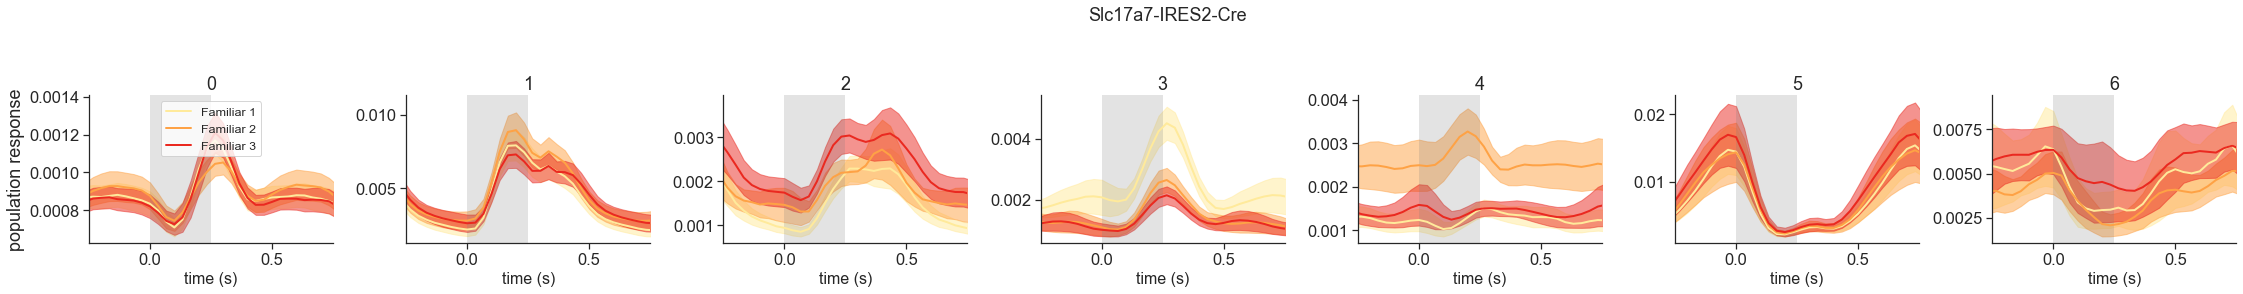

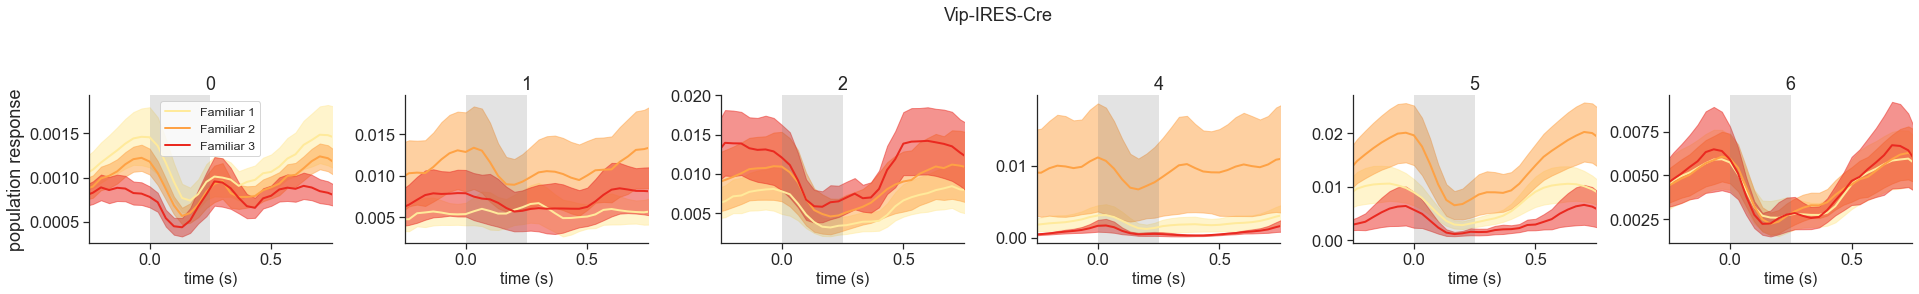

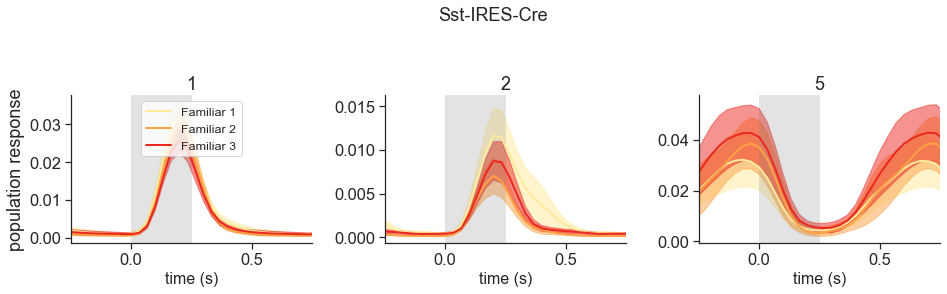

In [68]:
tmp = multi_session_df.copy()
tmp = tmp[tmp.is_change==False]
# add new experience level to to mdf by merging in cells_table
tmp = tmp.drop(columns='experience_level').merge(cells_table[['cell_specimen_id', 'ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id', 'cell_specimen_id'])
# add cluster_id by merging in cluster meta
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99))]
osids = [919888953, 931326814]
tmp = tmp[tmp.ophys_session_id.isin(osids)==False]

print(tmp.experience_level.unique())

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line].copy()

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    palette = sns.color_palette('YlOrRd', 6)[::2]
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-0.25, 0.75]

    suffix = '_cluster_image_response'

    ax = ppf.plot_population_averages_for_conditions(df, data_type, 'all',
                                                            axes_column, hue_column, horizontal=True,
                                                            xlim_seconds=xlim_seconds, interval_sec=0.5,
                                                            palette=palette, ax=None, title=None, suptitle=cre_line,
                                                            save_dir=None, folder=folder, suffix=suffix)


In [69]:

def plot_population_averages_for_conditions_multi_row(multi_session_df, data_type, event_type, axes_column, hue_column, row_column,
                                            project_code=None, timestamps=None, palette=None, title=None, suptitle=None,
                                            horizontal=True, xlim_seconds=None, interval_sec=1,
                                            save_dir=None, folder=None, suffix='', ax=None):
    if palette is None:
        palette = utils.get_experience_level_colors()

    sdf = multi_session_df.copy()
    if 'trace_timestamps' in sdf.keys():
        timestamps = sdf.trace_timestamps.values[0]
    elif timestamps is not None:
        timestamps = timestamps
    else:
        print('provide timestamps or provide a multi_session_df with a trace_timestamps column')

    if xlim_seconds is None:
        xlim_seconds = [timestamps[0], timestamps[-1]]
    if 'dff' in data_type:
        ylabel = 'dF/F'
    elif 'events' in data_type:
        ylabel = 'population response'
    elif 'pupil' in data_type:
        ylabel = 'pupil width\n(normalized)'
    elif 'running' in data_type:
        ylabel = 'running speed (cm/s)'
    elif 'lick' in data_type:
        ylabel = 'lick rate (licks/s)'
    else:
        ylabel = 'response'
    if event_type == 'omissions':
        omitted = True
        change = False
        xlabel = 'time after omission (s)'
    elif event_type == 'changes':
        omitted = False
        change = True
        xlabel = 'time after change (s)'
    else:
        omitted = False
        change = False
        xlabel = 'time (s)'

    row_conditions = np.sort(sdf[row_column].unique())
    if hue_column == 'experience_level':
        # hue_conditions = ['Familiar', 'Novel 1', 'Novel >1']
        hue_conditions = np.sort(sdf[hue_column].unique())
    else:
        hue_conditions = np.sort(sdf[hue_column].unique())
    if axes_column == 'experience_level':
        # axes_conditions = ['Familiar', 'Novel 1', 'Novel >1']
        axes_conditions = np.sort(sdf[axes_column].unique())
    else:
        axes_conditions = np.sort(sdf[axes_column].unique())
    # if there is only one axis condition, set n conditions for plotting to 2 so it can still iterate
    if len(axes_conditions) == 1:
        n_axes_conditions = 2
    else:
        n_axes_conditions = len(axes_conditions)
    n_row_conditions = len(row_conditions)
    if ax is None:
        format_fig = True
        if horizontal:
            figsize = (4.5 * n_axes_conditions, 4 * n_row_conditions)
            fig, ax = plt.subplots(n_row_conditions, n_axes_conditions, figsize=figsize, sharey='row')
        else:
            figsize = (5* n_row_conditions, 3.5 * n_axes_conditions)
            fig, ax = plt.subplots(n_axes_conditions, n_row_conditions, figsize=figsize, sharex=True)
        ax = ax.ravel()
    else:
        format_fig = False
    i = 0
    for r, row in enumerate(row_conditions):
        for a, axis in enumerate(axes_conditions):
            try:
                for c, hue in enumerate(hue_conditions):
                    cdf = sdf[(sdf[axes_column] == axis) & (sdf[hue_column] == hue) & (sdf[row_column]==row)]
                    traces = cdf.mean_trace.values

                    ax[i] = utils.plot_mean_trace(np.asarray(traces), timestamps, ylabel=ylabel,
                                                legend_label=hue, color=palette[c], interval_sec=interval_sec,
                                                xlim_seconds=xlim_seconds, ax=ax[i])
                ax[i] = utils.plot_flashes_on_trace(ax[i], timestamps, change=change, omitted=omitted)
                if omitted:
                    omission_color = sns.color_palette()[9]
                    ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color=omission_color)
                if title == 'metadata':
                    metadata_string = utils.get_container_metadata_string(utils.get_metadata_for_row_of_multi_session_df(cdf))
                    ax[i].set_title(metadata_string)
                else:
                    if axes_column == 'experience_level':
                        title_colors = utilities.get_experience_level_colors()
                        ax[i].set_title(axis, color=title_colors[i], fontsize=20)
                    else:
                        ax[i].set_title(axis)
                if title:  # overwrite title if one is provided
                    ax[i].set_title(title)
                ax[i].set_xlim(xlim_seconds)
                ax[i].set_xlabel(xlabel, fontsize=16)
                if horizontal:
                    ax[i].set_ylabel('')
                else:
                    ax[i].set_ylabel(ylabel)
                    ax[i].set_xlabel('')
            except:
                print('no data for', axis, hue)
            i+=1
                
        if format_fig:
            if horizontal:
                ax[0].set_ylabel(row_conditions[0]+'\n'+ylabel)
                ax[len(axes_conditions)].set_ylabel(row_conditions[1]+'\n'+ylabel)
                ax[2*len(axes_conditions)].set_ylabel(row_conditions[2]+'\n'+ylabel)
            else:
                ax[i].set_xlabel(xlabel)
        # ax[0].legend(loc='upper right', fontsize='x-small') # title='passive', title_fontsize='xx-small')

    if project_code:
        if suptitle is None:
            suptitle = 'population average - ' + data_type + ' response - ' + project_code[14:]
    else:
        if suptitle is None:
            suptitle = 'population average response - ' + data_type + '_' + event_type
    if format_fig:
        plt.suptitle(suptitle, x=0.52, y=1.04, fontsize=18)
        fig.tight_layout()
        if horizontal:
            fig.subplots_adjust(wspace=0.3)

    if save_dir:
        fig_title = 'population_average_' + axes_column + '_' + row_column + '_' + hue_column + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)

    return ax

['Familiar' 'Novel >1' 'Novel 1']
1432


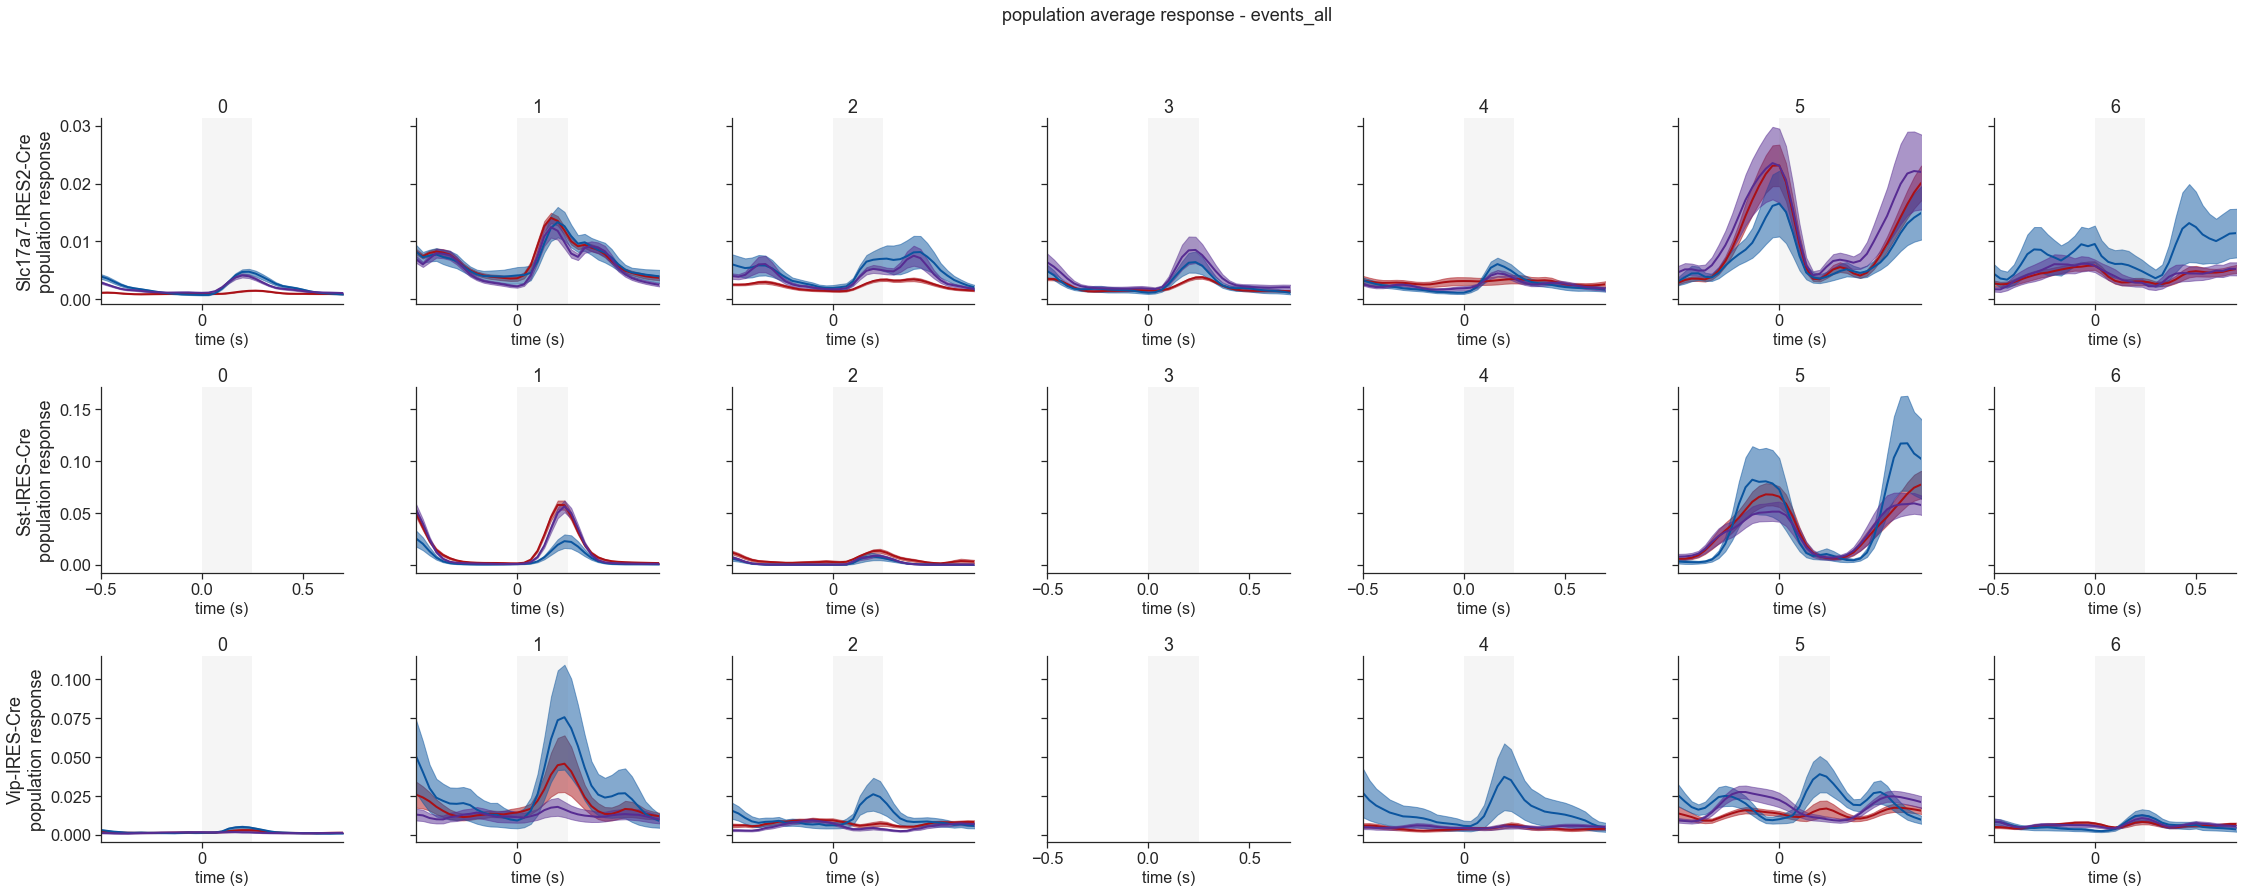

In [70]:
tmp = multi_session_df.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]
print(tmp.experience_level.unique())
print(len(tmp.cell_specimen_id.unique()))

xlim_seconds = [-0.5, 0.7]
timestamps = tmp.trace_timestamps.values[0]


plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', axes_column='cluster_id', hue_column='experience_level', row_column='cre_line',
                                            project_code=None, timestamps=None, palette=None, title=None, suptitle=None,
                                            horizontal=True, xlim_seconds=xlim_seconds, interval_sec=1,
                                            save_dir=None, folder=None, suffix='', ax=None);

In [71]:
no_outliers = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]
len(no_outliers)

18017

In [72]:
len(tmp)-len(no_outliers)

31

In [73]:
np.percentile(tmp.mean_response.values, 99.9)

0.24473656808180355

In [74]:
tmp[tmp.mean_baseline>np.percentile(tmp[(tmp.cre_line=='Sst-IRES-Cre')].mean_baseline.values, 99.5)]

,cell_specimen_id,is_change,mean_response,sem_response,mean_trace,sem_trace,trace_timestamps,mean_responses,mean_baseline,sem_baseline,...,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,cluster_id
756,1086542627,False,0.132906,0.005384,"[0.022844442920115223, 0.0312230378450957, 0.0...","[0.0032800966409806133, 0.003408204384846647, ...","[-2.0, -1.9666666666665187, -1.933333333333329...","[0.1959504460242355, 0.0, 0.26526366714198685,...",0.175594,0.007374,...,VISp_upper,20190606,False,NaN,False,False,False,False,Familiar 2,1
757,1086542627,True,0.089306,0.016019,"[0.013621867231393837, 0.02382228864950282, 0....","[0.009795673091207616, 0.010784543639121678, 0...","[-2.0, -1.966666666666659, -1.9333333333333305...","[0.0, 0.0, 0.0, 0.1126354858424376, 0.04784220...",0.184872,0.027539,...,VISp_upper,20190606,False,NaN,False,False,False,False,Familiar 2,1
1688,1086496277,False,0.175219,0.012014,"[0.14712196086355858, 0.14792742104370726, 0.1...","[0.013108255261034011, 0.012956167131221446, 0...","[-2.0, -1.9666666666665094, -1.933333333333342...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.178981,0.011818,...,VISl_upper,20190613,False,NaN,False,False,False,False,Familiar > 3,4
1689,1086496277,True,0.176331,0.040389,"[0.19926925883349692, 0.19900886834000514, 0.1...","[0.06172405260652115, 0.06145949958987934, 0.0...","[-2.0, -1.9666666666666657, -1.933333333333321...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.227356,0.044202,...,VISl_upper,20190613,False,NaN,False,False,False,False,Familiar > 3,4
1702,1086496927,False,0.095299,0.004653,"[0.030595553399952898, 0.03323495394603292, 0....","[0.0059228415378937225, 0.006021686349431457, ...","[-2.0, -1.9666666666665187, -1.933333333333329...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.162264,0.007037,...,VISl_upper,20190606,False,NaN,False,False,False,False,Familiar 2,5
1703,1086496927,True,0.123773,0.022037,"[0.06816457931301154, 0.06475925380691488, 0.0...","[0.03649251760737971, 0.03527126470838875, 0.0...","[-2.0, -1.966666666666659, -1.9333333333333305...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2141729618851...",0.164968,0.027307,...,VISl_upper,20190606,False,NaN,False,False,False,False,Familiar 2,5
1900,1086590617,False,0.116898,0.008062,"[0.0569071905370735, 0.05604243077921585, 0.05...","[0.011689957015162115, 0.011041352974875067, 0...","[-2.0, -1.9666666666665111, -1.933333333333339...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.92709072...",0.197201,0.013102,...,VISl_lower,20190610,False,NaN,False,False,False,False,Novel 1,5
1901,1086590617,True,0.155654,0.030204,"[0.03202235138633359, 0.028871321499835723, 0....","[0.03197590850273971, 0.02882944864023691, 0.0...","[-2.0, -1.9666666666666648, -1.933333333333323...","[0.0, 0.0, 0.9455702359136257, 0.0, 0.0, 0.0, ...",0.151411,0.031326,...,VISl_lower,20190610,False,NaN,False,False,False,False,Novel 1,5
4070,1086569794,False,0.304566,0.019625,"[0.2828479803169479, 0.26609562779669305, 0.22...","[0.026545912977891082, 0.024799446462726894, 0...","[-2.0, -1.9666666666665293, -1.933333333333315...","[0.0, 0.0, 3.3385860363480244, 0.0, 1.55437582...",0.144917,0.011048,...,VISp_upper,20191205,False,-3.0,False,False,False,False,Familiar 2,1
4177,1086574274,True,0.296070,0.084832,"[0.575643871288865, 0.5507795451524833, 0.4936...","[0.20731619745411856, 0.20466061170007543, 0.1...","[-2.0, -1.9666666666666566, -1.933333333333336...","[0.0, 0.0, 0.0, 0.0, 0.0, 9.728645550727702, 0...",0.191289,0.073034,...,VISp_upper,20191205,False,-3.0,False,False,False,False,Familiar 2,4


In [75]:
data = tmp[(tmp.cre_line=='Sst-IRES-Cre') & (tmp.cluster_id==8)]
data[data.mean_baseline>0.4]

,cell_specimen_id,is_change,mean_response,sem_response,mean_trace,sem_trace,trace_timestamps,mean_responses,mean_baseline,sem_baseline,...,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,cluster_id


In [76]:
np.percentile(tmp[(tmp.cre_line=='Sst-IRES-Cre') & (tmp.cluster_id==8)].mean_response.values, 99)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
tmp.columns

In [ ]:
df = tmp[tmp.is_change==False]

xlim_seconds = [-0.5, 0.7]

event_type = 'all'

timestamps = tmp.trace_timestamps.values[0]
row_condition = 'experience_level'
col_condition = 'cluster_id'
cols_to_sort_by = ['mean_response']

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]


    ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, event_type,
                                          row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
                                          microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
                                          save_dir=None, folder=folder, suffix='', ax=None)


# ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, event_type,
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle='',
#                                           microscope=None, vmax=None, xlim_seconds=[-2, 2], match_cells=False, cbar=True,
#                                           save_dir=save_dir, folder=folder, suffix='_cbar', ax=None)

#### omissions

In [ ]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']


omission_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

omission_mdf = omission_mdf[omission_mdf.omitted==True]

In [ ]:
tmp = multi_session_df.copy()
tmp = tmp[tmp.is_change==False]
# add new experience level to to mdf by merging in cells_table
tmp = tmp.drop(columns='experience_level').merge(cells_table[['cell_specimen_id', 'ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id', 'cell_specimen_id'])
# add cluster_id by merging in cluster meta
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99))]
osids = [919888953, 931326814]
tmp = tmp[tmp.ophys_session_id.isin(osids)==False]


for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    palette = palette = sns.color_palette('YlOrRd', 6)[::2]
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-1, 1.5]

    suffix = '_cluster_omission_response'

    ax = ppf.plot_population_averages_for_conditions(df, data_type, 'omissions',
                                                            axes_column, hue_column, horizontal=True,
                                                            xlim_seconds=xlim_seconds, interval_sec=0.5,
                                                            palette=palette, ax=None, title=None, suptitle=cre_line,
                                                            save_dir=None, folder=folder, suffix=suffix)


In [ ]:
tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


xlim_seconds = xlim_seconds=[-1, 1.5]

event_type = 'all'

timestamps = tmp.trace_timestamps.values[0]
row_condition = 'experience_level'
col_condition = 'cluster_id'
cols_to_sort_by = ['mean_response']

for cre_line in tmp.cre_line.unique():
    df = tmp[tmp.cre_line==cre_line]


    ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, 'omissions',
                                          row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
                                          microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
                                          save_dir=None, folder=folder, suffix='', ax=None)


# ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, event_type,
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle='',
#                                           microscope=None, vmax=None, xlim_seconds=[-2, 2], match_cells=False, cbar=True,
#                                           save_dir=save_dir, folder=folder, suffix='_cbar', ax=None)

### within session changes

In [ ]:
# params for stim response df creation
event_type = 'changes'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change', 'epoch']


suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

epoch_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

# epoch_mdf = epoch_mdf[epoch_mdf.is_change==False]

In [ ]:
original_epoch_mdf = epoch_mdf.copy()
# remove truncated last epoch
epoch_mdf = epoch_mdf[epoch_mdf.epoch!=6]
# add cluster IDs
epoch_mdf = epoch_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
# plot for all cells within each cre line
ppf.plot_mean_response_by_epoch(epoch_mdf, metric='mean_response', horizontal=True, ymin=0, ylabel='mean response', estimator=np.mean,
                                save_dir=None, folder='epochs', max_epoch=6, suptitle=None, suffix='', ax=None)

In [ ]:

def plot_mean_response_by_epoch_overlay(df, metric='mean_response',ymin=0, ylabel='mean response', estimator=np.mean, max_epoch=6,
                                        title='', legend=True, save_dir=None, folder=folder, suffix='', ax=None):
    """
    Plots the mean metric value across epochs within a session, colored by experience level
    :param df: dataframe of cell activity with one row per cell_specimen_id / ophys_experiment_id
                must include columns 'cell_type', 'experience_level', 'epoch', and a column for the metric provided (ex: 'mean_response')
    :param metric: metric value to average over epochs; must be a column of df
    :param save_dir: top level directory to save figure to
    :param folder: folder within save_dir to save figure to; will create folder if it doesnt exist
    :param suffix: string to append at end of saved filename
    :return:
    """

    experience_levels = np.sort(df.experience_level.unique())

    df = df[df.epoch <= max_epoch]
    epochs = np.sort(df.epoch.unique())

    palette = utils.get_experience_level_colors()
    if ax is None:
        figsize = (6, 3.5)
        fig, ax = plt.subplots(figsize=figsize)

    ax = sns.pointplot(data=df, x='epoch', y=metric, hue='experience_level', hue_order=experience_levels,
                                  order=epochs, palette=palette, ax=ax, estimator=estimator)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if ymax is not None: 
        ax.set_ylim(ymax=ymax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlim((epochs[0] - 1, epochs[-1] + 1))
    ax.set_xticks(epochs)
    ax.set_xticklabels(epochs+1)
    ax.set_xlabel('epoch within session')
    if not legend: 
        ax.get_legend().remove()

    
    if save_dir:
        fig_title = metric + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)
    return ax

In [ ]:
cre_lines = np.sort(epoch_mdf.cre_line.unique())
i = 0
cre_line = cre_lines[i]

cluster_ids = np.sort(epoch_mdf.cluster_id.unique())

figsize=(25,3)
fig, ax = plt.subplots(1, len(cluster_ids), figsize=figsize, sharey=False)
for i, cluster_id in enumerate(cluster_ids): 
    df = epoch_mdf[(epoch_mdf.cre_line==cre_line) & (epoch_mdf.cluster_id==cluster_id)].copy()

    ax[i] = plot_mean_response_by_epoch_overlay(df, metric='mean_response', ymin=0, ymax=None, ylabel='mean response', estimator=np.mean, max_epoch=6,
                                            title='cluster '+str(cluster_id), legend=False, save_dir=None, folder=folder, suffix='', ax=ax[i])
    ax[i].set_ylabel('')
ax[0].set_ylabel('mean response')

plt.subplots_adjust(wspace=0.4)
plt.suptitle(cre_line, x=0.5, y=1.1)

### cluster metrics

In [ ]:
# coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

In [ ]:
def get_cluster_metrics_all_cre(cluster_meta, feature_matrix, results_pivoted):
    """
    computes metrics for each cluster, including experience modulation, feature selectivity, etc
    """
    # cell_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)
    cluster_metrics = pd.DataFrame()
    # get cell specimen ids 
    cell_specimen_ids = cluster_meta.index.values
    # get unique cluster labels
    cluster_labels = np.sort(cluster_meta.cluster_id.unique())
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster 
        this_cluster_csids = cluster_meta[cluster_meta['cluster_id'] == cluster_id].index.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(feature_matrix.loc[this_cluster_csids].mean().unstack())
        stats = processing.get_coding_metrics(index_dropouts=mean_dropout_df.T, index_value=cluster_id,
                                    index_name='cluster_id')
        fraction_cells = len(this_cluster_csids) / float(len(cell_specimen_ids))
        stats['fraction_cells'] = fraction_cells
        stats['F_max'] = mean_dropout_df['Familiar'].max()
        stats['N1_max'] = mean_dropout_df['Novel 1'].max()
        stats['N2_max'] = mean_dropout_df['Novel >1'].max()
        stats['abs_max'] = mean_dropout_df.max().max()
        cluster_metrics = pd.concat([cluster_metrics, stats])
    cluster_metrics = cluster_metrics.reset_index()
    print(cluster_metrics.keys())
    n_cells = cluster_meta.groupby(['cluster_id']).count()[['labels']].rename(columns={'labels': 'n_cells_cluster'})
    cluster_metrics = cluster_metrics.merge(n_cells, on=['cluster_id'])

    return cluster_metrics

In [ ]:
# cluster_metrics = get_cluster_metrics_all_cre(cluster_meta, feature_matrix, results_pivoted)
# cluster_metrics

In [ ]:
# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.head()

#### fraction clusters & cells per feature

In [ ]:
def get_cluster_counts(cluster_metrics, groupby='dominant_feature'):
    cluster_counts = pd.DataFrame()

    for cre_line in cluster_metrics.cre_line.unique():
        cre_clusters = cluster_metrics[cluster_metrics.cre_line==cre_line]
        total = len(cre_clusters)
        count = cre_clusters.groupby(groupby).count()[['cluster_id']].rename(columns={'cluster_id':'n_clusters'})
        count['fraction'] = count.n_clusters / total
        count['cre_line'] = cre_line
        count = count.reset_index()
        cluster_counts = pd.concat([cluster_counts, count])

    return cluster_counts

In [ ]:

groupby = 'dominant_feature'
order = ['all-images', 'omissions', 'behavioral', 'task']

cluster_counts = get_cluster_counts(cluster_metrics, groupby=groupby)

figsize = (2, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  y=groupby, order=order, x='n_clusters', 
                color='gray', width=0.6, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].set_yticklabels(order, fontsize=14, va='center')

ax[2].set_xlabel('number of clusters')
# ax[i].set_ylabel('preferred feature')
ax[i].set_yticklabels(order, fontsize=14, va='center')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred feature category', x=0.5, y=1.05, fontsize=16)


In [ ]:

groupby = 'dominant_feature'
order = ['all-images', 'omissions', 'behavioral', 'task']

cluster_counts = get_cluster_counts(cluster_metrics, groupby=groupby)

figsize = (2, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  y=groupby, order=order, x='fraction', 
                color='gray', width=0.6, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[2].set_xlabel('fraction clusters')
# ax[i].set_ylabel('preferred feature')
# ax[i].set_yticklabels(order, rotation=90)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred feature category', x=0.5, y=1.05, fontsize=16)


In [ ]:
def get_cell_counts(cluster_metrics, groupby='dominant_feature'):
    cell_counts = pd.DataFrame()

    for cre_line in cluster_metrics.cre_line.unique():
        cre_clusters = cluster_metrics[cluster_metrics.cre_line==cre_line]
        total = cre_clusters.n_cells_cluster.sum()
        count = cre_clusters.groupby(groupby).sum()[['n_cells_cluster']]
        count['fraction'] = count.n_cells_cluster / total
        count['cre_line'] = cre_line
        count = count.reset_index()
        cell_counts = pd.concat([cell_counts, count])

    return cell_counts

In [ ]:

groupby = 'dominant_feature'
order = ['all-images', 'omissions', 'behavioral', 'task']

cell_counts = get_cell_counts(cluster_metrics, groupby=groupby)

figsize = (2, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cell_counts[cell_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  y=groupby, order=order, x='fraction', 
                color='gray', width=0.6, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[2].set_xlabel('fraction cells')
# ax[i].set_ylabel('preferred feature')
# ax[i].set_xticklabels(order, rotation=90)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred feature category', x=0.5, y=1.05, fontsize=16)

#### cluster and cell counts by pref experience level

In [ ]:

groupby = 'dominant_experience_level'
order = ['Familiar', 'Novel 1', 'Novel >1']

cluster_counts = get_cluster_counts(cluster_metrics, groupby)

figsize = (1.75, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x=groupby, order=order, y='n_clusters', 
                color='gray', palette=experience_level_colors, width=0.5, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[1].set_ylabel('number of clusters')
# ax[i].set_xlabel('preferred\nexperience level')
ax[i].set_xticklabels(order, rotation=90, fontsize=14)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred\nexperience level', x=0.5, y=1.05, fontsize=16)

In [ ]:

# groupby = 'dominant_experience_level'
# order = ['Familiar', 'Novel 1', 'Novel >1']

# cluster_counts = get_cluster_counts(cluster_metrics, groupby)

# figsize = (2, 5)
# fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
# for i, cre_line in enumerate(cre_lines):
#     cre_data = cluster_counts[cluster_counts.cre_line==cre_line]
#     # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
#     ax[i] = sns.barplot(data=cre_data,  x=groupby, order=order, y='fraction', 
#                 color='gray', width=0.5, ax=ax[i])
#     ax[i].set_ylabel('')
#     ax[i].set_xlabel('')
#     ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

# ax[1].set_ylabel('fraction clusters')
# ax[i].set_xlabel('preferred\nexperience level')
# ax[i].set_xticklabels(order, rotation=90)
# sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

# plt.subplots_adjust(hspace=0.5)

In [ ]:

groupby = 'dominant_experience_level'
order = ['Familiar', 'Novel 1', 'Novel >1']

cell_counts = get_cell_counts(cluster_metrics, groupby=groupby)

figsize = (1.75, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    cre_data = cell_counts[cell_counts.cre_line==cre_line]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x=groupby, order=order, y='fraction', 
                color='gray', palette=experience_level_colors, width=0.5, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

ax[1].set_ylabel('fraction of cells')
# ax[i].set_xlabel('preferred\nexperience level')
ax[i].set_xticklabels(order, rotation=90, fontsize=14)
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('preferred experience level', x=0.5, y=1.05, fontsize=16)

### sort by pref coding score then exp level

In [ ]:
def sort_cluster_meta_by_feature_exp(cluster_meta, cluster_metrics):
    """
    sorts and replaces cluster_ids in cluster_meta with new cluster IDs that are orderd
    by the dominant feature then the dominant experience level of each cluster. 
    dominant feature is the coding score category (ex: images, omissions) with the strongest average coding score
    dominant experience level is the exp level with the strongest coding score for the preferred feature
    
    cluster_meta: table of metadata for each cell_specimen_id (the index) including a column 'cluster_id'
    cluster_metrics: table of metrics computed on the average coding scores for each cluster, 
                    produced by the function get_cluster_metrics_all_cre
    """
    metrics = cluster_metrics.copy()

    # get cluster IDs for all image clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='all-images'].sort_values(by='dominant_experience_level').cluster_id.unique()
    print(sorted_cluster_ids)
    n_clusters = len(sorted_cluster_ids)
    cluster_id_remap_df = pd.DataFrame(sorted_cluster_ids, np.arange(0, n_clusters))

    # get cluster IDs for omissions clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='omissions'].sort_values(by='dominant_experience_level').cluster_id.unique()
    new_cluster_ids = np.arange(n_clusters, n_clusters+len(sorted_cluster_ids)) 
    n_clusters = n_clusters+len(sorted_cluster_ids)
    # add to dataframe
    for i,  new_cluster_id in enumerate(new_cluster_ids):
        cluster_id_remap_df.at[new_cluster_id, 0] = sorted_cluster_ids[i]

    # get cluster IDs for behavior clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='behavioral'].sort_values(by='dominant_experience_level').cluster_id.unique()
    new_cluster_ids = np.arange(n_clusters, n_clusters+len(sorted_cluster_ids)) 
    n_clusters = n_clusters+len(sorted_cluster_ids)
    # add to dataframe
    for i,  new_cluster_id in enumerate(new_cluster_ids):
        cluster_id_remap_df.at[new_cluster_id, 0] = sorted_cluster_ids[i]

    # get cluster IDs for task clusters sorted by exp level
    sorted_cluster_ids = metrics[metrics.dominant_feature=='task'].sort_values(by='dominant_experience_level').cluster_id.unique()
    new_cluster_ids = np.arange(n_clusters, n_clusters+len(sorted_cluster_ids)) 
    n_clusters = n_clusters+len(sorted_cluster_ids)
    # add to dataframe
    for i,  new_cluster_id in enumerate(new_cluster_ids):
        cluster_id_remap_df.at[new_cluster_id, 0] = sorted_cluster_ids[i]

    # reformat column names
    cluster_id_remap_df.index.name = 'new_cluster_id'
    cluster_id_remap_df = cluster_id_remap_df.rename(columns={0: 'cluster_id'})
    cluster_id_remap_df = cluster_id_remap_df.reset_index()
    # set cluster ids to ints
    cluster_id_remap_df['cluster_id'] = [int(cluster_id) for cluster_id in cluster_id_remap_df.cluster_id.values]

    # merge remapped IDs into cluster meta
    cluster_meta_tmp = cluster_meta.reset_index().merge(cluster_id_remap_df, on='cluster_id').copy()
    cluster_meta_tmp = cluster_meta_tmp.set_index('cell_specimen_id')
    cluster_meta = cluster_meta_tmp.copy()

    return cluster_meta

In [ ]:
# cluster_meta = sort_cluster_meta_by_feature_exp(cluster_meta, cluster_metrics)

In [ ]:
# cluster_meta_tmp = cluster_meta.reset_index().merge(cluster_id_remap_df, on='cluster_id').copy()
# cluster_meta_tmp = cluster_meta_tmp.set_index('cell_specimen_id')

# plot_all_cre_clustering_heatmap(cluster_meta, feature_matrix, sort_by='new_cluster_id', orient='horiz', session_colors=True,
#                                     save_dir=save_dir, folder=folder, ax=None)

### split by cre line and plot heatmaps

In [ ]:
# plot feature matrix sorted by cluster ID
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', resort_by_size=True,
                                    save_dir=None, folder=folder)

In [ ]:
# plot feature matrix sorted by cluster ID
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', resort_by_size=False,
                                save_dir=save_dir, folder=folder)

### average dropouts per cluster

In [ ]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)


feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)


figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+str(n_clusters))

#### averages per cre line

In [ ]:
# all cre lines on one plot

feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)

clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters = len(clusters)

figsize = (2.5*n_clusters, 2.5*3)
fig, ax = plt.subplots(3, n_clusters, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

i=0
for c, cre_line in enumerate(np.sort(cluster_meta.cre_line.unique())):
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    # loop through clusters in sorted order
    for x, cluster_id in enumerate(clusters):
        try:
            this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
            mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
            ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
            # fraction is number of cells in this cluster vs all cells in this cre line
            fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
            fraction = np.round(fraction_cluster * 100, 1)
            # set title and labels
            ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
            ax[i].set_xlabel('')
        except:
            pass
        i+=1
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    # plt.suptitle(cre_line, x=0.46, y=1.)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped')

In [ ]:
# plot each cre line separately

feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()
    clusters = np.sort(cre_cluster_meta['cluster_id'].unique())
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+cre_line.split('-')[0])

#### sort by cluster size within cre, exclude clusters with <10% cells

In [ ]:
# plot clusters in order of sort_col

feature_matrix_remapped, remapped_cmap, vmax = remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    clusters = cre_cluster_meta['cluster_id'].value_counts().index.values    
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_sorted_'+cre_line.split('-')[0])

In [ ]:
# plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col='cluster_id', 
#                                             save_dir=save_dir, folder=folder)

In [ ]:
# # plot each separately
# clusters = np.sort(cluster_meta['cluster_id'].unique())
# n_clusters_to_plot = len(clusters)

# abbreviate_features = True
# abbreviate_experience = True

# # loop through clusters and plot each one with abbreviated labels
# for i, cluster_id in enumerate(clusters):
#     figsize=(2,1.7)
#     fig, ax = plt.subplots(figsize=figsize)
#     this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
#     mean_dropout_df = feature_matrix.loc[this_cluster_csids].mean().unstack()
#     ax = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax, cbar=False, cbar_kws={'label': 'coding score'})
#     # fraction is number of cells in this cluster vs all cells in this cre line
#     fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
#     fraction = np.round(fraction_cluster * 100, 1)
#     # set title and labels
#     ax.set_title('cluster ' + str(cluster_id))
# #     ax.set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
#     ax.set_xlabel('')
#     if abbreviate_features:
#         # set yticks to abbreviated feature labels
#         feature_abbreviations = plotting.get_abbreviated_features(mean_dropout_df.index.values)
#         ax.set_yticklabels(feature_abbreviations, rotation=0)
#     else:
#         ax.set_yticklabels(mean_dropout_df.index.values, rotation=0, fontsize=14)
#     if abbreviate_experience:
#         # set xticks to abbreviated experience level labels
#         exp_level_abbreviations = plotting.get_abbreviated_experience_levels(mean_dropout_df.columns.values)
#         ax.set_xticklabels(exp_level_abbreviations, rotation=90)
#     else:
#         ax.set_xticklabels(mean_dropout_df.columns.values, rotation=90, fontsize=14)
    
#     if test_save_dir:
#         utils.save_figure(fig, figsize, save_dir, 'folder,
#                           'mean_cluster_heatmap_cluster_'+str(i))

### within cluster correlation

In [ ]:
n_clusters_cre = {}
for cre in cre_lines: 
    n_clusters_cre[cre] = len(cluster_meta.cluster_id.unique())
plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=None, suffix='', save_dir=save_dir, folder=folder)

In [ ]:
figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=cluster_meta, x='cluster_id', y='within_cluster_correlation', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, width=0.6, showfliers=False, ax=ax)
ax.set_ylabel('within cluster correlation')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

### cre line proportions per cluster

In [ ]:
def get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group='mouse_id'):
    """
    counts the number of cells a given condition, and the number of cells in each cluster for that given ocndition,
    then computes the proportion of cells in each cluster for the given condition
    col_to_group: can be 'cre_line', 'mouse_id', etc
    """
    # get number of cells in each group defined by col_to_group
    n_cells_group = cluster_meta.groupby([col_to_group]).count()[['cluster_id']].reset_index().rename(columns={'cluster_id':'n_cells_group'})
    # get number of cells in each cluster for each group
    n_cells_per_cluster = cluster_meta.groupby([col_to_group, 'cluster_id']).count()[['ophys_experiment_id']].reset_index().rename(columns={'ophys_experiment_id':'n_cells_cluster'})
    # add n cells per cluster per group to total number of cells per group and compute the fraction per cluster in each group
    n_cells_per_cluster = n_cells_per_cluster.merge(n_cells_group, on=col_to_group)
    n_cells_per_cluster['fraction_per_cluster'] = n_cells_per_cluster.n_cells_cluster/n_cells_per_cluster.n_cells_group
    
    return n_cells_per_cluster

In [ ]:
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue=col_to_group, hue_order=cre_lines, palette=cre_line_colors, width=0.5, ax=ax)
ax.set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
# sorted within cre
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

figsize = (25,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre in enumerate(cre_lines):
    cre_data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre]
    order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data,  x='cluster_id', order=order, y='fraction_per_cluster', 
                hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, width=0.5, ax=ax[i])
    ax[i].set_ylabel('fraction in each cluster')
    ax[i].get_legend().remove()
    ax[i].set_ylim(0, 0.3)
#     ax[i].legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')
    ax[i].set_title(cre)

### per mouse

In [ ]:
col_to_group = 'mouse_id'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)
n_cells_per_cluster = n_cells_per_cluster.merge(experiments_table[['mouse_id', 'cre_line']], on='mouse_id')
n_cells_per_cluster = n_cells_per_cluster.drop_duplicates(subset=['mouse_id', 'cluster_id'])
n_cells_per_cluster

In [ ]:
figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.barplot(data=n_cells_per_cluster, x='cluster_id', y='fraction_per_cluster', 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, ax=ax)
ax.set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
figsize = (20,4)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    data = n_cells_per_cluster[n_cells_per_cluster.cre_line==cre_line]
    ax[i] = sns.stripplot(data=data, x='cluster_id', y='fraction_per_cluster', 
                          order=np.arange(0, len(n_cells_per_cluster.cluster_id.unique())),
                color=cre_line_colors[i], ax=ax[i])
    ax[i] = sns.barplot(data=data, x='cluster_id', y='fraction_per_cluster', 
                        order=np.arange(0, len(n_cells_per_cluster.cluster_id.unique())),
                color='gray', ax=ax[i])
    ax[i].set_ylabel('fraction of cells per '+col_to_group+'\nin each cluster')
    ax[i].set_title(cre_line)

### is 15 clusters reasonable?

### eigengap

In [ ]:
# k_max=25
# X = feature_matrix.values
# sc = SpectralClustering(n_clusters)  # N of clusters does not impact affinity matrix
# # but you can obtain affinity matrix only after fitting, thus some N of clusters must be provided.
# sc.fit(X)
# A = sc.affinity_matrix_
# eigenvalues, eigenvectors, nb_clusters = processing.get_eigenDecomposition(A, max_n_clusters=k_max)

In [ ]:
# figsize = (10, 4)
# fig, ax = plt.subplots(figsize=figsize)
# # ax.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, '-o')
# # ax.set_ylabel('Eigen values \n(sorted)')
# # ax.set_xlabel('Eigen number')
# # ax.set_xlim([0, 20])
# # ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

# ax.plot(np.arange(2, len(eigenvalues) + 1), np.diff(eigenvalues), '-o')
# ax.set_ylabel('Eigengap value \n(difference)')
# ax.set_xlabel('Eigen number')
# ax.set_xlim([0, 20])
# # ax.set_ylim([0, 0.20])
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')
# plt.tight_layout()

# if test_save_dir:
#     utils.save_figure(fig, figsize, test_save_dir, 'figs', 'eigengap')

### gap statistic

In [ ]:
# X = feature_matrix.values
# feature_matrix_shuffled = processing.shuffle_dropout_score(feature_matrix, shuffle_type='all')
# reference = feature_matrix_shuffled.values
# sc = SpectralClustering()
# gap_statistic, reference_inertia, ondata_inertia = processing.compute_gap(sc, X, k_max=25, reference_shuffle=reference, 
#                                                                 metric='euclidean', n_boots=20)

In [ ]:
# figsize = (10, 4)
# fig, ax = plt.subplots(figsize=figsize)

# ax.plot(np.arange(1, x + 1), gap_statistic['reference_inertia'], 'o-')
# ax.plot(np.arange(1, x + 1), gap_statistic['ondata_inertia'], 'o-')
# ax.legend(['reference inertia', 'ondata intertia'])
# ax.set_ylabel('Natural log of euclidean \ndistance values')
# ax.set_xlabel('Number of clusters')
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

# ax.plot(np.arange(1, x + 1), gap_statistic['gap'], 'o-')
# ax.set_ylabel('Gap statistic')
# ax.set_xlabel('Number of clusters')
# ax.axvline(x=n_clusters, ymin=0, ymax=1, linestyle='--', color='gray')

### compute metrics on dropout scores for each cell

In [ ]:
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

metrics: 
* exp_mod_direction = N - F / N + F
* exp_mod_persistence = N+ - N / N+ + N

In [ ]:
print(len(coding_score_metrics.mouse_id.unique()), 'mice')
print(len(coding_score_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(coding_score_metrics.index.unique()), 'cells')

In [ ]:
cluster_meta

In [ ]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)

figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_'+str(n_clusters))

In [ ]:
metric = 'exp_mod_direction'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
n_clusters = len(coding_score_metrics.cluster_id.unique())

In [ ]:
metric = 'exp_mod_direction'

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.pointplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.2, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

for x in np.arange(0.5, n_clusters, 1):
    ax.vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
ax.hlines(y=0, xmin=-0.5, xmax=n_clusters-0.5, color='gray', linestyle='--')

#### persistence of coding

In [ ]:
metric = 'exp_mod_persistence'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
# take absolute value so its just whether it is transient or not, regardless of direction
coding_score_metrics['transience'] = np.abs(coding_score_metrics.exp_mod_persistence.values)

In [ ]:
metric = 'transience'

figsize = (20,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
metric = 'transience'

figsize = (15,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.pointplot(data=coding_score_metrics, x='cluster_id', y=metric, 
            hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.2, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
ax.set_ylabel(metric)
ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

for x in np.arange(0.5, n_clusters, 1):
    ax.vlines(x=x, ymin=0, ymax=1, color='gray', linestyle='--')

In [ ]:
# # vertical plot
# metric = 'persistence'

# figsize = (5, 10)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.pointplot(data=coding_score_metrics, y='cluster_id', x=metric, orient='h',
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.3, ax=ax)
# # ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
# #             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_xlabel(metric)
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

# for y in np.arange(0.5, len(coding_score_metrics.cluster_id.unique()), 1):
#     ax.hlines(y=y, xmin=0, xmax=1, color='gray', linestyle='--')

### model free metrics

In [ ]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

Response metrics table contains one row per cell per experiment

In [ ]:
data_type = 'events'

condition = 'images'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

In [ ]:
# convert experience level

response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in response_metrics.experience_level.values]

In [ ]:
# limit to matched cells
response_metrics = response_metrics[response_metrics.cell_specimen_id.isin(matched_cells)]
len(response_metrics)

In [ ]:
print(len(response_metrics.mouse_id.unique()), 'mice')
print(len(response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(response_metrics.cell_specimen_id.unique()), 'cells')

In [ ]:
print(len(cluster_meta.mouse_id.unique()), 'mice')
print(len(cluster_meta.index.unique()), 'cells')

In [ ]:
response_metrics = response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
response_metrics.head()

In [ ]:
metrics = ['image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index',]

In [ ]:
cluster_ids = cluster_meta.cluster_id.unique()
n_clusters = len(cluster_ids)


In [ ]:
metric = 'lifetime_sparseness'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=0, ymax=1, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
# metric = 'reliability'

# order = np.arange(0, n_clusters, 1)

# figsize = (35,5)
# fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
# for i, cre_line in enumerate(cre_lines):
#     data = response_metrics[response_metrics.cre_line==cre_line]
#     ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
#                 hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
#                           join=False, dodge=0.3, ax=ax[i])
#     ax[i].set_title(cre_line)
#     ax[i].get_legend().remove()
#     ax[i].set_ylabel('')
#     for x in np.arange(0.5, n_clusters, 1):
#         ax[i].vlines(x=x, ymin=0, ymax=0.5, color='gray', linestyle='--')
    
# ax[0].set_ylabel(metric)
# ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

# plt.subplots_adjust(wspace=0.1)

In [ ]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

### preferred stimulus response reliability

In [ ]:
data_type = 'events'

condition = 'images'
stimuli = 'pref_image'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
pref_stim_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

In [ ]:
# convert experience level
pref_stim_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in pref_stim_response_metrics.experience_level.values]
# limit to matched cells
pref_stim_response_metrics = pref_stim_response_metrics[pref_stim_response_metrics.cell_specimen_id.isin(matched_cells)]
# add cluster ID
pref_stim_response_metrics = pref_stim_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=0, ymax=0.5, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

### omission responses per cluster 

In [ ]:
data_type = 'events'

condition = 'omissions'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
omission_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

In [ ]:
omission_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in omission_response_metrics.experience_level.values]

In [ ]:
# limit to matched cells
omission_response_metrics = omission_response_metrics[omission_response_metrics.cell_specimen_id.isin(matched_cells)]
len(omission_response_metrics)

print(len(omission_response_metrics.mouse_id.unique()), 'mice')
print(len(omission_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(omission_response_metrics.cell_specimen_id.unique()), 'cells')

omission_response_metrics = omission_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = omission_response_metrics[omission_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-0.1, ymax=0.5, color='gray', linestyle='--')
    ax[i].set_ylim(-0.1, 0.5)
    
ax[0].set_ylabel('omission reliability')
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

#### change response metrics

In [ ]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

In [ ]:
data_type = 'events'

condition = 'changes'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
change_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

In [ ]:
# convert experience level 
change_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in change_response_metrics.experience_level.values]

In [ ]:
# limit to matched cells
change_response_metrics = change_response_metrics[change_response_metrics.cell_specimen_id.isin(matched_cells)]
len(change_response_metrics)

print(len(change_response_metrics.mouse_id.unique()), 'mice')
print(len(change_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(change_response_metrics.cell_specimen_id.unique()), 'cells')

change_response_metrics = change_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
change_response_metrics.keys()

In [ ]:
metric = 'hit_miss_index'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
    ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
metric = 'change_modulation_index'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
    ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters, 1)

figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=-0.2, ymax=0.5, color='gray', linestyle='--')
    ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

# plot clusters individually with metric values

What is available?
* coding_score_metrics
* response_metrics
* omission_response_metrics
* change_response_metrics
* fraction cells per cluster

In [ ]:
col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)


## test each plot

### dropout heatmaps

In [ ]:
cluster_id = 1

plotting.plot_dropout_heatmap(cluster_meta, feature_matrix, cluster_id, cre_line=None, 
                            abbreviate_features=True, abbreviate_experience=True, small_fontsize=False, ax=None)

### pie chart fraction cells per cluster

In [ ]:

def plot_fraction_per_cluster_pie(n_cells_per_cluster, cluster_id, cre_line=None, ax=None):
       if cre_line is not None: 
              fractions_this_cre = n_cells_per_cluster[(n_cells_per_cluster.cre_line==cre_line)].fraction_per_cluster.values
              fractions_this_cluster = n_cells_per_cluster[(n_cells_per_cluster.cre_line==cre_line)&(n_cells_per_cluster.cluster_id==cluster_id)].fraction_per_cluster.values[0]
              fraction = np.round(fractions_this_cluster*100, 2)
       else: 
              fractions_this_cluster = n_cells_per_cluster[(n_cells_per_cluster.cluster_id==cluster_id)].fraction_per_cluster.values[0]
              fraction = np.round(fractions_this_cluster*100, 2)   

       colors = utils.get_cre_line_color_dict()
       colors = [colors[cre_line], [0.8, 0.8, 0.8]]

       if ax is None:
              fig, ax = plt.subplots(figsize=(2,2.5))
       ax.pie(x=[fraction, 100 - fraction], colors=colors, wedgeprops=dict(edgecolor='w'),
              startangle=90, radius=1, center=(-1, 0), labels=[str(fraction) + '%', ''])
       ax.set_title(utils.get_abbreviated_cell_type(cre_line))

       return ax

In [ ]:
cluster_id = 1
cre_line = 'Vip-IRES-Cre'

col_to_group = 'cre_line'
n_cells_per_cluster = get_fraction_cells_per_cluster_per_group(cluster_meta, col_to_group)

plot_fraction_per_cluster_pie(n_cells_per_cluster, cluster_id, cre_line, ax=None)


In [ ]:

def plot_cluster_proportion_per_cre(n_cells_per_cluster, cluster_id, ax=None):
    """
    Plots a stacked barplot of the proportion of cells in each cluster, split by each cre line
    x axis is cre line, y axis is proportion
    each cre line is sorted by its own fraction per cluster in ascending order
    the cluster_id provided will be colored according to the cre line and the size of that cluster will be plotted
    at the top of the stacked barplot
    """
    this_cluster = cluster_id
    if ax is None: 
        fig, ax = plt.subplots(figsize=(3,3))
    for x_pos, cre_line in enumerate(cre_lines):
        data = n_cells_per_cluster[(n_cells_per_cluster.cre_line == cre_line)]
        data['fraction'] = data.fraction_per_cluster
        data = data.sort_values(by=['fraction'], ascending=True)
        cluster_ids = data.cluster_id.values
        len_this_cluster = len(data[data.cluster_id == this_cluster])
        if len_this_cluster>0:
            cluster_is_present = True
        next_bar_start = 0
        for c, cluster_id in enumerate(cluster_ids):
            this_value = data[data.cluster_id == cluster_id].fraction.values[0]
            if (cluster_id == this_cluster) and (cluster_is_present==True): # only plot a color and label if its the cluster of interest
                color = cre_line_colors[x_pos]
                label = str(np.round(this_value*100, 1))+'%'
                ax.text(x_pos-0.4, 1.05, label, fontsize='x-small')
            else:
                color = 'gray'
            if c == 0:
                ax.bar(x_pos, this_value, bottom=next_bar_start, color=color, edgecolor='w')
            else:
                ax.bar(x_pos, this_value, bottom=next_bar_start, color=color, edgecolor='w')
            next_bar_start = next_bar_start + this_value
            # ax.axis('off')
            sns.despine(left=True, bottom=True)
            ax.tick_params(left=False, bottom=False)
    ax.set_xticks(np.arange(0,3))
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines])
    ax.set_yticklabels('')
    ax.set_ylabel('cluster proportion\nper cell type')
    return ax

In [ ]:
cluster_id = 0
plot_cluster_proportion_per_cre(n_cells_per_cluster, cluster_id, ax=None)


### coding score metrics per cluster

In [ ]:
coding_score_metrics.keys()

In [ ]:
cluster_data

In [ ]:
coding_score_metrics.cre_line.unique()

In [ ]:
def plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=-1, ymax=1, ylabel=None, ax=None):
    """
    plots distribution of a given coding score metric for a given cluster, for each cre line
    shows boxplot and individual data points
    cre line is on x axis, metric value on y axis
    """
    cluster_data = coding_score_metrics[coding_score_metrics.cluster_id==cluster_id]

    if ax is None: 
        figsize=(2,2.5)
        fig, ax = plt.subplots(figsize=figsize)

    # ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                     palette=cre_line_colors, ax=ax)

    ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
                color='white', width=0.5, ax=ax)
    ax = sns.stripplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
                palette=cre_line_colors, size=3, alpha=0.5, ax=ax)

    # ax.legend([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines], fontsize='xx-small')
    # ax.get_legend().remove()
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines])
    ax.set_xlabel('')
    if ylabel is not None:
        ax.set_title(ylabel)
        ax.set_ylabel('')
    # ax.set_ylabel('')
    # ax.set_title(metric)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-0.5, len(cre_lines)-0.5)
    ax.hlines(y=0, xmin=-0.5, xmax=len(cre_lines)-0.5, color='gray', linestyle='--')

    return ax


In [ ]:
cluster_id = 1
metric = 'experience_selectivity'

plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ax=None)


In [ ]:
# take absolute value so its just whether it is transient or not, regardless of direction
coding_score_metrics['persistence'] = 1-np.abs(coding_score_metrics.exp_mod_persistence.values)

In [ ]:
cluster_id = 1
metric = 'persistence'

plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=0, ax=None)


### response metrics per cluster

In [ ]:
def plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-1, ymax=1, ylabel=None, ax=None):
    """
    plots distribution of a given response metric (computed on cell traces directly) for a given cluster, for each cre line
    shows boxplot and individual data points
    cre line is on x axis, metric value on y axis
    """
    cluster_data = response_metrics[response_metrics.cluster_id==cluster_id]

    if ax is None: 
        figsize=(2,2.5)
        fig, ax = plt.subplots(figsize=figsize)

    # ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                     palette=cre_line_colors, ax=ax)

    ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, width=0.7,
                    hue='experience_level',hue_order=experience_levels, boxprops=dict(alpha=.6), 
                    palette=experience_level_colors, ax=ax)

    # ax = sns.pointplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                 hue='experience_level',hue_order=experience_levels, join=False, dodge=True, 
    #                 palette=experience_level_colors, ax=ax)
                    
    # ax = sns.boxplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                 hue='experience_level',hue_order=experience_levels, dodge=True,
    #                 color='white', width=0.5, ax=ax)
    # ax = sns.stripplot(data=cluster_data, x='cre_line', order=cre_lines, y=metric, 
    #                 hue='experience_level',  hue_order=experience_levels,
    #                 palette=experience_level_colors, dodge=True, size=3, alpha=0.5, ax=ax)

    # ax.legend([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines], fontsize='xx-small')
    ax.get_legend().remove()
    ax.set_xticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in cre_lines])
    ax.set_xlabel('')
    if ylabel is not None: 
        ax.set_title(ylabel)
        ax.set_ylabel('')
    # ax.set_ylabel('')
    # ax.set_title(metric)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-0.5, len(cre_lines)-0.5)
    if ymin < -0.05: 
        ax.hlines(y=0, xmin=-0.5, xmax=len(cre_lines)-0.5, color='gray', linestyle='--')

    return ax


In [ ]:
cluster_id = 1
metric = 'lifetime_sparseness'
plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-0.1, ymax=1.1, ax=None)

In [ ]:
cluster_id = 1
metric = 'running_modulation_index'
plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-1.1, ymax=1.1, ax=None)

In [ ]:
response_metrics.keys()

In [ ]:
cluster_id = 0
metric = 'reliability'

plot_response_metric_for_cluster(pref_stim_response_metrics, cluster_id, metric, ymin=-0.6, ymax=1.1, ax=None)

In [ ]:
[2] + [int(x) for x in list(np.ones(7))]

In [ ]:
cluster_id = 1

def plot_cluster_properties(cluster_id): 
    figsize = (25,2.5)
    width_ratios = [1.5] + [int(x) for x in list(np.ones(7))]
    fig, ax = plt.subplots(1, 8, figsize=figsize, gridspec_kw={'width_ratios':width_ratios})

    i = 0
    ax[i] = plotting.plot_dropout_heatmap(cluster_meta, feature_matrix, cluster_id, cre_line=None, 
                                abbreviate_features=True, abbreviate_experience=True, small_fontsize=False, ax=ax[i])
    i+=1
    ax[i] = plot_cluster_proportion_per_cre(n_cells_per_cluster, cluster_id, ax=ax[i])
    i+=1
    metric = 'experience_selectivity'
    ax[i] = plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=-1.1, ymax=1.1, ylabel='novelty index', ax=ax[i])
    i+=1
    metric = 'persistence'
    ax[i] = plot_coding_score_metric_for_cluster(coding_score_metrics, cluster_id, metric, ymin=-0.1, ymax=1.1, ylabel='persistence', ax=ax[i])
    i+=1
    metric = 'lifetime_sparseness'
    ax[i] = plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-0.1, ymax=1.1, ylabel='image selectivity', ax=ax[i])
    i+=1
    metric = 'reliability'
    ax[i] = plot_response_metric_for_cluster(pref_stim_response_metrics, cluster_id, metric, ymin=-0.6, ymax=1.1, ylabel='image \nreliability', ax=ax[i])
    i+=1
    metric = 'reliability'
    ax[i] = plot_response_metric_for_cluster(omission_response_metrics, cluster_id, metric, ymin=-0.6, ymax=1.1, ylabel='omission \nreliability', ax=ax[i])
    i+=1
    metric = 'running_modulation_index'
    ax[i] = plot_response_metric_for_cluster(response_metrics, cluster_id, metric, ymin=-1.1, ymax=1.1, ylabel='running\nmodulation', ax=ax[i])

    plt.subplots_adjust(wspace=0.7)
    # plt.tight_layout()

    utils.save_figure(fig, figsize, save_dir, folder, 'cluster_properties_cluster_'+str(cluster_id))

plot_cluster_properties(cluster_id)

In [ ]:
for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
    plot_cluster_properties(cluster_id)

### within session changes for each cluster

#### test that sdf and get_mean_df work

In [ ]:
import visual_behavior.ophys.response_analysis.utilities as ut


In [ ]:
event_type = 'all'
data_type = 'events'

In [ ]:
ophys_experiment_id = experiments_table.index[20]

dataset = loading.get_ophys_dataset(ophys_experiment_id)

sdf = loading.get_stimulus_response_df(dataset, data_type=data_type, event_type=event_type, time_window=[-2,2.1],
                                                      interpolate=True, output_sampling_rate=30,
                                                      load_from_file=True, epoch_duration_mins=10)

In [ ]:

output_sampling_rate = sdf.output_sampling_rate.values[0]
response_window_duration = sdf.response_window_duration.values[0]

conditions = ['cell_specimen_id', 'is_change', 'omitted', 'epoch']

mdf = ut.get_mean_df(sdf, conditions=conditions, frame_rate=output_sampling_rate,
                                     window_around_timepoint_seconds=[-2, 2.1],
                                     response_window_duration_seconds=response_window_duration,
                                     get_pref_stim=False, exclude_omitted_from_pref_stim=True)

### load multi session df

In [ ]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'

In [ ]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
# conditions = ['cell_specimen_id', 'image_name', 'epoch']
conditions = ['cell_specimen_id', 'is_change', 'omitted', 'epoch']


suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=10)

# change_mdf = change_mdf[change_mdf.is_change==True]

In [ ]:
multi_session_df.groupby(['session_type', 'project_code']).count()

### create multi session df for one set of conditions

In [ ]:
import visual_behavior.ophys.io.create_multi_session_df as io

conditions = ['cell_specimen_id', 'is_change', 'omitted', 'epoch']
data_type = 'events'
event_type = 'all'

df = io.get_multi_session_df('VisualBehavior', 4, conditions, data_type, event_type,
                                             time_window=[-2,2.1], interpolate=True, output_sampling_rate=30,
                                             response_window_duration=0.5,
                                             use_extended_stimulus_presentations=False,
                                             epoch_duration_mins=10, overwrite=True)

In [ ]:
figsize = (35,5)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = multi_session_df[multi_session_df.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='epoch', y='mean_response', 
                hue='experience_level', hue_order=experience_levels, palette=palette_experience, 
                          join=False, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
#     for x in np.arange(0.5, n_clusters, 1):
#         ax[i].vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
#     ax[i].hlines(y=0, xmin=-0.5, xmax=n_clusters, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
### create multi session df

get_multi_session_df(project_code, session_number, conditions, data_type, event_type,
                         time_window=[-3, 3.1], interpolate=True, output_sampling_rate=30,
                         response_window_duration=0.5, epoch_duration_mins=5,
                         use_extended_stimulus_presentations=False, overwrite=True)